# ML in Cybersecurity: Task I

## Team
  * **Team name**:  *R2D2C3P0BB8*
  * **Members**:  <br/> **Navdeeppal Singh (s8nlsing@stud.uni-saarland.de)** <br/> **Shahrukh Khan (shkh00001@stud.uni-saarland.de)** <br/> **Mahnoor Shahid (mash00001@stud.uni-saarland.de)**


## Logistics
  * **Due date**: 11th November 2021, 23:59:59 (email the completed notebook including outputs to mlcysec_ws2022_staff@lists.cispa.saarland)
  * Please include your team name and the task number in the file name and the email subject
  * Complete this in **teams of 3**
  * Feel free to use the forum or the mailing list to find group members.
  
## Timeline
  * 29-Oct-2021: Task 1 hand-out
  * **11-Nov-2021** (23:59:59): Email the completed notebook including outputs to mlcysec_ws2022_staff@lists.cispa.saarland
  * 12-Nov-2021: Task 1 discussion and summary
  
  
## About this task
In this task, you'll implement a digit classifier, based on the popular [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The dataset is based on a seminal [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), which immensely popularized (convolutional) neural networks. This is a great starting point for ML research and this dataset/model has been a stepping stone numerous other tasks such as [GANs](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), [Adversarial Perturbations](https://arxiv.org/abs/1412.6572) and so many more!

This dataset consists of data $\mathcal{D} = \{x_i, y_i\}_{i=1}^N$, where $x_i$ is a 28x28 pixel grayscale image and $y_i$ is a scalar represeting digits between 0-9. The notebook will guide you to load this data, implement classifiers $\hat{y_i} = f_w(x_i)$  and analyze results. By doing so, you'll have a ML model that works on real data!

To put things into context, have a look at Slide 21 in the [second](https://cms.cispa.saarland/mlcysec19/dl/4/2019-10-24-ml.pdf) lecture. Within this framework, the following blocks of this task are fixed:
  * *Real-world problem*: Digit classification
  * *Performance metric*: Mean accuracy i.e., $ \frac{1}{N} \sum_{i=1}^N \mathbb{1}[\hat{y_i} = y_i]$, where $\mathbb{1}[\hat{y_i} = y_i]$ is 1 if your model predicted the right digit for the $i$-th digit and 0 otherwise.
  * *Data*: The MNIST dataset

You'll make the the following design-choices:
 * *Choice of Model*: A model family (Non-parametric methods, Linear classifiers, Neural Networks, etc.)
 * *ML Model*: Specific model (e.g., SVM with a polynomial kernel)
 * *Loss/Risk*
 * *Optimization*


## A Note on Grading
The grading for this task will depend on:
 1. Functional digit classifier
   * Following a well-defined ML pipeline
   * Developing 3 classification models (keep them diverse and ideally of increasing complexity)
   * Obtaining reasonable accuracies (>80%) on a held-out test set
 1. Analysis
   * Which methods work better than the rest and why?
   * Which hyper-parameters and design-choices were important in each of your methods?
   * Quantifying influence of these hyper-parameters on loss and/or validation accuracies
   * Trade-offs between methods, hyper-parameters, design-choices
    * Anything else you find interesting (this part is open-ended)
  
 A note on (1.): 
  * Choose your models that aids good insights. We require at least one non-Neural Network (e.g., SVM, KNN) and one Neural Network model (e.g., MLP, CNN).
  * We definitely don't expect all three models to achieve >99% test accuracies!

## Grading Details
 * 5 points for loading and visualization 
 * 25x3 points for models. Per model:
   * 4 points for written description 
   * 7 points for implementation
   * 7 points for evaluation
   * 7 points for summary
 * 15 points for final summary (Section 3)
 * 5 points for clean code
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.


**The notebook is your task report. So, to make the report readable, omit code for techniques/models/things that did not work. You can use final summary to provide report about these codes.**

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v2.0: Added pytorch
  * v1.1: Added Code of Honor
  * v1.0: Initial notebook
  
  ---

In [5]:
import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn

import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances, plot_slice
import IPython
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [6]:
# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.

# We only support sklearn and pytorch.
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
# Please set random seed to have reproduceable results, e.g. torch.manual_seed(123)
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)


Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [7]:

def identity_func(foo):
    return foo

"""
function that returns separately, inputs and labels
when given list of tuples of inputs and label pairs
For example:

input: [(input_image_1, label_1), ...,(input_image_n, label_n)]
output: ([input_image_1, ..., input_image_n], [label_1, ..., label_n])
flatten_input: parameter which controls whether input should be flattened or not, 
if selected then returns numpy variables X(flattened_input), y(labels)

"""        
        
def get_inputs_labels(dataset, flatten_input=False):
    inputs = []
    labels = []
    for example in dataset:
            inputs.append(example[0])
            labels.append(example[1])
    X = torch.cat(inputs, dim=0)
    y = torch.Tensor(labels)
    if flatten_input:
        X = flatten_input_pixels(X)
        y = y.numpy()
        
    return (X,y)


# You can use this function to flatten 2D inputs
def flatten_input_pixels(x_input):
    result = []
    for i in range(len(x_input)):
        result.append(x_input[i].flatten().numpy())
    return np.array(result, np.float32)  # [n_samples, n_features]


# You can use this function to plot the accuracy of the models with different parametes
def plot_scores(x, y, title = "Title", x_label = "X", y_label = "Y"):
    fig, ax = plt.subplots(nrows=1,ncols=1)

    ax.plot(x, y)
    ax.set_xticks(x)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(0.6, 1.0)
    
    
# You can use this function to plot the accuracy of the models with different parametes
def plot_all_scores(scores, title = "Title", x_label = "Validation ", y_label = "Y"):
    fig, ax = plt.subplots(nrows=1,ncols=1)
    colors = ["black", "purple", "blue", "brown", "olive", "red", "green", "gray", "teal", "cyan", "hotpink", "khaki"]
    for idx, score in enumerate(scores):
        x, y, label = score
        lines = ax.plot(x, y, label=label, color=colors[idx])

    plt.legend(loc="lower right")
    ax.set_xticks(x)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(0.85, 1.0)
    
    
## train vs evaluation comparison plot
def plot_train_eval_scores(train_scores, evaluation_scores, title = "Title", x_label = "X", y_label = "Y", rows=1, cols=1):
    fig, ax = plt.subplots(nrows=rows,ncols=cols, figsize=(20,20))
    row = 0
    if rows > 1 or cols > 1:
        for i in range(rows):
            for j in range(cols):
                try:
                    train_x, train_y, label_train = train_scores[row]
                    eval_x, eval_y, label_eval = evaluation_scores[row]
                    ax[i][j].plot(train_x, train_y, label="train_scores")
                    ax[i][j].plot(eval_x, eval_y, label="eval_scores")
                    ax[i][j].set_title(label_train)
                    ax[i][j].set_ylim(0.6, 1.1)
                    row+=1
                except:
                    pass
    else:
        train_x, train_y, label_train = train_scores[row]
        eval_x, eval_y, label_eval = evaluation_scores[row]
        ax.plot(train_x, train_y, label="train_scores")
        ax.plot(eval_x, eval_y, label="eval_scores")
        ax.set_title(label_train)
        ax.set_ylim(0.6, 1.1)

        
# You can use this function to visualize input images and the predictions of your models
# "y_pred" is output of your model 
# "n_val" is number of instances in test or validation sets
def vis_predictions(x_eval, y_pred, n_val):
    rows, cols = 4, 3

    fig,ax = plt.subplots(nrows = rows, ncols = cols)

    ids = np.random.randint(0,n_val,rows*cols)
    for i in range(cols):   
        for j in range(rows):
            ax[j][i].set_title('predicted label: {0}'. format(y_pred[ids[(i*rows)+j]]))
            two_d = (np.reshape(x_eval[ids[(i*rows)+j]], (28, 28))).astype(np.float32)
            ax[j][i].imshow(two_d)
            ax[j][i].axes.get_xaxis().set_visible(False)
            ax[j][i].axes.get_yaxis().set_visible(False)


    plt.tight_layout()  


def imshow(inp, title=None):
    inp = inp.numpy().squeeze()
    plt.imshow(inp, cmap='gray_r')
    if title is not None:
        plt.title(title)
    
    
def visualize_specific_predictions(specific_predictions):
    target_values = []
    predicted_values = []
    figure = plt.figure(figsize=(20, 10))
    columns = 6
    rows = 3
    axs = []
    for index, (images, targets, predictions) in list(enumerate(specific_predictions))[:18]:
        with warnings.catch_warnings(record=True):
            axs.append( figure.add_subplot(rows, columns, index+1) )
            axs[-1].set_title(f'Correct: {targets}, Predicted: {predictions}', fontsize=14)
            axs[-1].axis("off")
            plt.imshow(images.cpu().reshape(28, 28))
    plt.show()
    

# 1. Loading and Visualizing data (5 points)

In this section, you'll need to prepare the MNIST data for the experiments you'll be conducting for the remainder of the notebook.

## 1.1. Load Data

Here you'll load the MNIST data into memory. The end-goal is to two have the following variables:
  * `x_trainval`, `x_test`: of shape $N \times d_1 \times d_2 \dots$ (e.g., $N \times 784$. 784 since you could flatten each 28x28 pixel image into a single vector)
  * `y_trainval`, `y_test`: of shape $N \times K$ (K = 1 or 10 depending on how you plan to represent the ground-truth digit annotation)

You can either do this by:
  1. Downloading the MNIST dataset, unpacking and preparing it yourself to have fine-grained control
  1. Using high-level existing functions, such as the one provided by  [`torchvision.datasets`](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist).
  
  
  In either case, it is important that you have disjoint train, val, and test splits!

In [8]:

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train = torchvision.datasets.MNIST(root='../data', 
                                        train=True,
                                        download=True,
                                     transform=transform)


x_trainval, y_trainval = get_inputs_labels(train, flatten_input=False)

test = torchvision.datasets.MNIST(root='../data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)

x_test, y_test = get_inputs_labels(test, flatten_input=False)

print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))

#
# Feel free to have multiple variables in case your models are designed for different formats
# For instance, in case your model requires Nx28x28 inputs, declare x_trainval_3d, etc.

# Tip: Set this to a tiny number (such 0.05) to aid debugging
# After all, you do not want to train/evaluate on the entire dataset to find bugs
DEBUG_FRAC = 1.0
x_trainval = x_trainval[:int(len(x_trainval)*DEBUG_FRAC)]
y_trainval = y_trainval[:int(len(y_trainval)*DEBUG_FRAC)]


x_trainval.shape = torch.Size([60000, 28, 28]),  y_trainval.shape = torch.Size([60000])
x_test.shape = torch.Size([10000, 28, 28]),  y_test.shape = torch.Size([10000])


#### 1.2. Visualize Data

To get the hang of your data you'll be training a digit classifier on, visualize it.

Examples of ways to visualize it:
  * Given a digit, display few randomly sampled images for this digit (the bare minimum)
  * Visualize as a grid (e.g., Slide 4, [Lecture 2](https://cms.cispa.saarland/mlcysec19/dl/4/2019-10-24-ml.pdf)) using a combination of `plt.imshow` and `plt.subplots`
  
It's up to you to decide how you want to do this. The end-goal is for you to potentially give a trailer of the dataset to someone who hasn't seen it before.

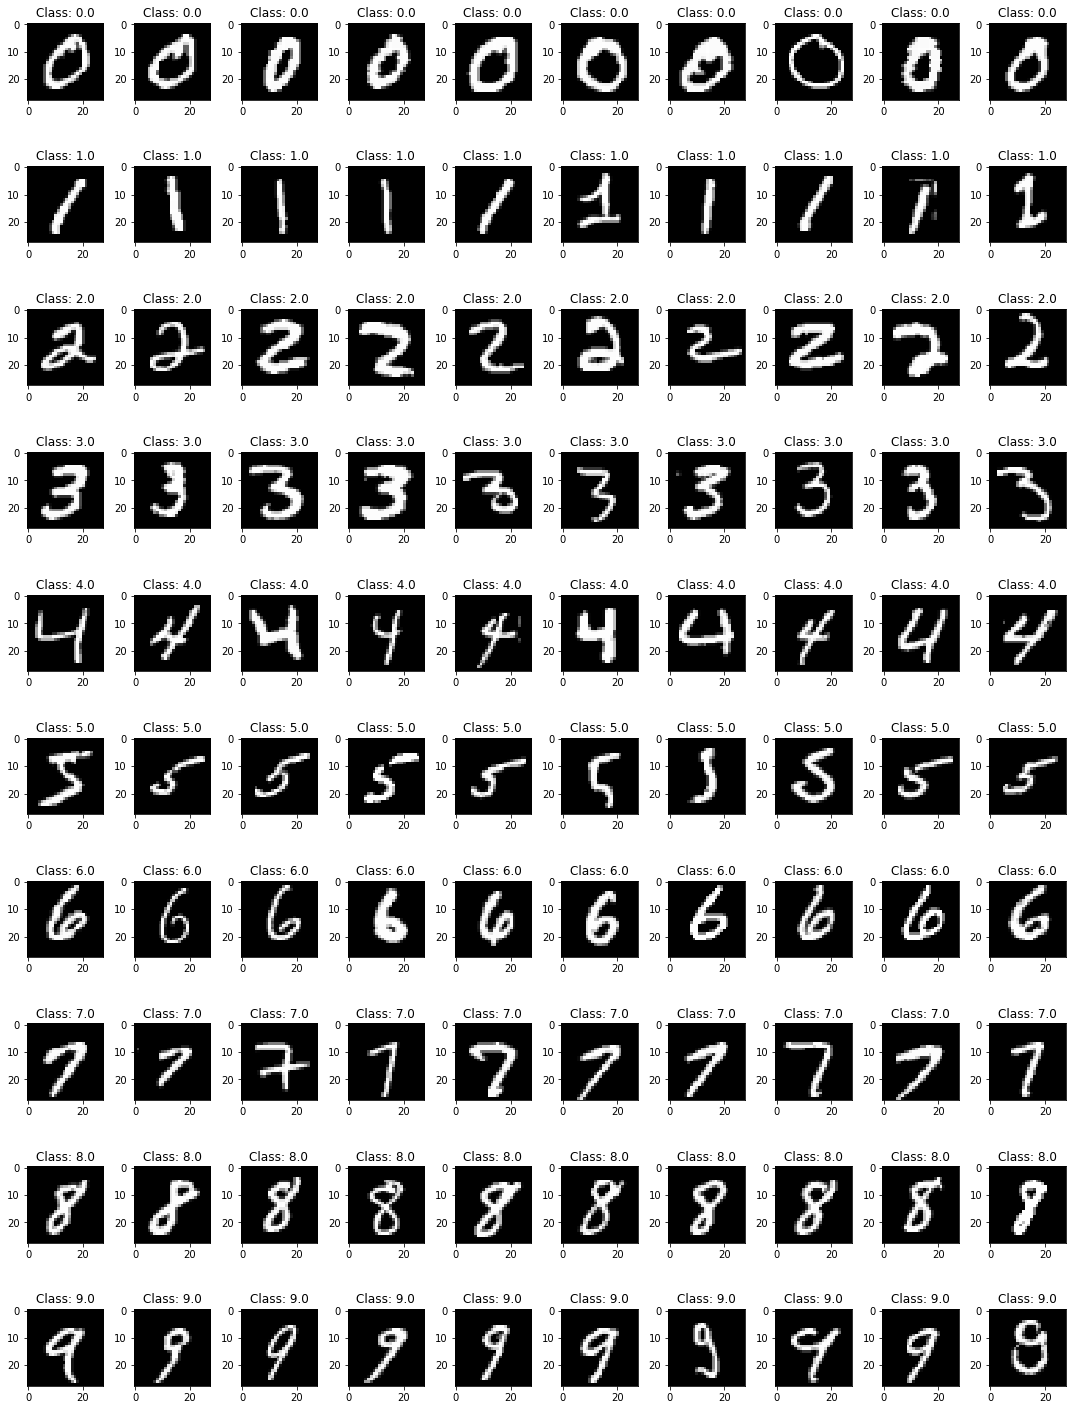

In [9]:
# Visualize 10 examples of 10 classes. You can extend the following code:
rows, cols = 10, 10
num_classes = 10
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(1.5*rows,2*cols))
current_label = -1 ## capture which label to visualize in current row

for i in range(rows*cols):
    if i%num_classes == 0: ## detects when to switch to next row of labels
        current_label += 1
        result = np.where(y_trainval == current_label)  
    axis = ax[i//cols, i%cols] ## finds the cell location in 10x10 grid to plot the current digit
    idx = result[0][:cols][i%cols] ## index of current data point
    axis.imshow(x_trainval[idx], cmap='gray') ## plots digit
    axis.set_title('Class: {}'.format(y_trainval[idx])) ## adds label as fig title
    
plt.tight_layout()
plt.savefig('fig1.pdf')   # Save the figures
plt.show()   # These should be some visualization of data at the end of this section

# You can see an output example in the follow:

#### 1.3. Dimensionality reduction and visualize groups per label

Bring data to two dimensions and visualize it in 2D.

In [10]:
## flatten traineval/test dataset
x_trainval_flattened, _ = get_inputs_labels(train, flatten_input=True)
x_test_flattened, _ = get_inputs_labels(test, flatten_input=True)
## perform dimensionality reduction
pca = decomposition.PCA(n_components=2, random_state=random_seed)
x_trainval_reduced = pca.fit_transform(x_trainval_flattened)

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


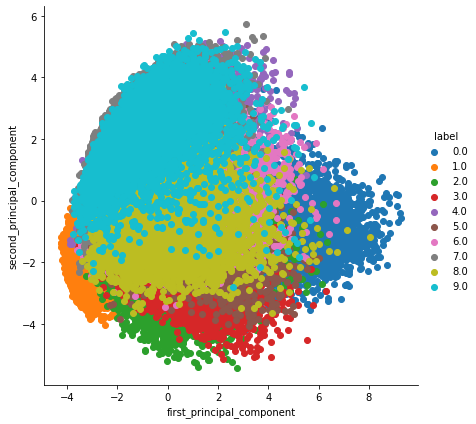

In [11]:
## convert to dataframe for visualization
reduced_dataset = pd.DataFrame(np.c_[x_trainval_reduced, y_trainval.numpy()], 
                               columns=["first_principal_component", "second_principal_component", "label"])
# plotting the 2d data points with seaborn
sns.FacetGrid(reduced_dataset, hue="label", size=6).map(plt.scatter, "first_principal_component", "second_principal_component").add_legend()
plt.show()

As apparent from the plot, the data is not linearly separable in two dimensions hence higher dimensional data must be used.

#### 1.4. Label distribution in training data

Visualizing the label counts per label in training data

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


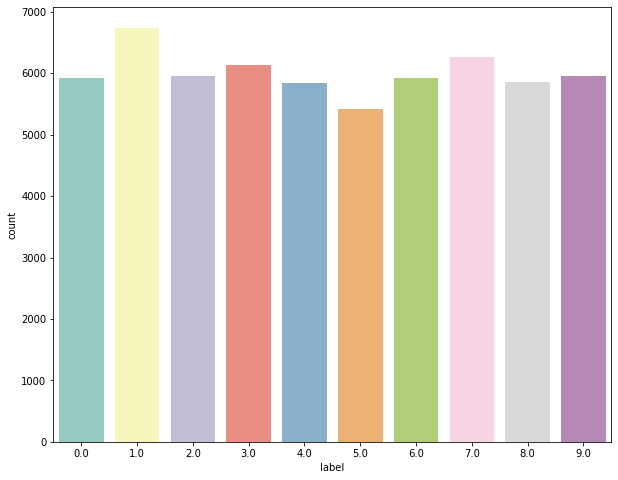

In [12]:
sns.countplot(reduced_dataset["label"], palette="Set3");

The counts roughly seem uniformly distributed across all 10 label classes.

# 2. Digit classifiers

In this section, you'll begin developing models to perform digit classification.

Each model needs to be structured like so:
  1. Give a brief reason which model you are going to train and why you choose it
  1. Define hyper-parameters for model and optimization procedure
  1. Define your model
  1. Define optimization method and fit model to data
  1. Summarize your findings







## 2.1: Model [M1]: K-Nearest Neighbors Classifier (25 points)

K-Nearest Neighbors Classifiers is a non-parameteric classifiers, which means it doesn't learn or compute any statistical parameters rather during training all input vectors and their labels are stored which means it only memorizes all the training examples in the n-dimensional feature space where n is the input dimension. During inference the classifier predicts based on the similarity/distance to neighbors and predicts the labels of the unseen examples based on the majority vote based on the labels of the neighbors.

We chose this model as start of any Machine Learning pipeline should start with simple baseline which produces reasonable results as the same time is not complex. As kNN is one of the simplest algorithm with only single hyperparameter K, it is trivial to train the model and tune the value of K so this made kNN one of the best candidates for first model.

### 2.1.1: Hyper-parameters

Define hyper-parameters for your model here

In [54]:
"""Flag to determine whether to train new models or load pre-trained models from disk"""
is_load_knn_models = True

"""Corresponds to number of neighbors"""
n_neighbors_values = [3, 10, 50, 100] 

"""This is the hyper parameter of PCA which will also influence our ML model design"""
#number of dimensions
output_dimension_values = [5, 25, 50, 100, 784 ]
 

test_set = 'test'  #val  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation

if test_set == 'val':
    x_trainval_idxs = np.array([idx for idx in range(len(x_trainval))])
    train_idxs, val_idxs, _, _ = train_test_split(x_trainval_idxs, x_trainval_idxs, test_size=0.20, 
                                                        random_state=random_seed)
    x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test

### 2.1.2: Data Preprocessing


In [55]:
## flattening the datasets
x_train_flat = flatten_input_pixels(x_train)
x_eval_flat = flatten_input_pixels(x_eval)

## input dimensions
input_dimensions = 784
pca_outputs = {}
pca_eval_outputs = {}
for output_dimension in output_dimension_values:
    if output_dimension == 784:
        pca_outputs[output_dimension] = x_train_flat
        pca_eval_outputs[output_dimension] = x_eval_flat
    else:
        pca = decomposition.PCA(n_components=output_dimension, random_state=random_seed)
        pca.fit(x_train_flat)
        pca_outputs[output_dimension] = pca.transform(x_train_flat)
        pca_eval_outputs[output_dimension] = pca.transform(x_eval_flat)
    print(pca_outputs[output_dimension].shape, pca_eval_outputs[output_dimension].shape)


(60000, 5) (10000, 5)
(60000, 25) (10000, 25)
(60000, 50) (10000, 50)
(60000, 100) (10000, 100)
(60000, 784) (10000, 784)


### 2.1.3: Model

Define your model here

In [44]:
knn_models = {}
from collections import namedtuple

KNN_Param = namedtuple('KNN_Param', ['n_neighbors', 'n_features'])

def init_knn_models():
    for n_neighbors in n_neighbors_values:
        for num_features in output_dimension_values:
            # defining the model
            param = KNN_Param(n_neighbors=n_neighbors, n_features=num_features)
            knn_models[param] = KNeighborsClassifier(n_neighbors=param.n_neighbors, n_jobs=-1)

### 2.1.4: Fit Model

Define optimization procedure and fit your model to the data

In [45]:
 # fit the model
def train_knn_models():
    for model_name in tqdm(list(knn_models.keys())):
        knn_models[model_name] = knn_models[model_name].fit(pca_outputs[model_name.n_features], y_train)
#  Please save the trained model

In [46]:
# saving the trained models
def save_knn_models():
    for model_name in tqdm(list(knn_models.keys())):
        file_name = f"models/knn_{str(model_name)}.pickle"
        with open(file_name, "wb") as file:
            pickle.dump(knn_models[model_name], file, protocol=pickle.HIGHEST_PROTOCOL)

In [49]:
# load the saved SVM model from disk
def load_knn_models():
    for n_neighbors in tqdm(n_neighbors_values):
        for num_features in output_dimension_values:
            param = KNN_Param(n_neighbors=n_neighbors, n_features=num_features)
            file_name = f"models/knn_{str(param)}.pickle"
            with open(file_name, 'rb') as file:
                knn_models[param] = pickle.load(file)

In [50]:
if is_load_knn_models:
    load_knn_models()
else:
    init_knn_models()
    train_knn_models()
    save_knn_models()

100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


### 2.1.5: Evaluation

Evaluate your model.
  * Evaluate models with different parameters 
  * Plot the score (accuracy) for each model using "plot_scores" function
  * Report score for the best model
  * Use "vis_predictions" function to visualize few examples of test/validation set with the corresponding predictions


In [236]:
# Example: y_pred = model.predict(x)

knn_prediction_scores = {}
for model_name in tqdm(list(knn_models.keys())):
    y_pred = knn_models[model_name].predict(pca_eval_outputs[model_name.n_features])
    knn_prediction_scores[model_name] = accuracy_score(y_eval, y_pred) 
knn_prediction_scores

100%|██████████| 20/20 [43:38<00:00, 130.91s/it] 


{KNN_Param(n_neighbors=3, n_features=5): 0.7171666666666666,
 KNN_Param(n_neighbors=3, n_features=25): 0.974,
 KNN_Param(n_neighbors=3, n_features=50): 0.978,
 KNN_Param(n_neighbors=3, n_features=100): 0.9754166666666667,
 KNN_Param(n_neighbors=3, n_features=784): 0.9726666666666667,
 KNN_Param(n_neighbors=10, n_features=5): 0.7434166666666666,
 KNN_Param(n_neighbors=10, n_features=25): 0.9703333333333334,
 KNN_Param(n_neighbors=10, n_features=50): 0.9731666666666666,
 KNN_Param(n_neighbors=10, n_features=100): 0.9704166666666667,
 KNN_Param(n_neighbors=10, n_features=784): 0.9664166666666667,
 KNN_Param(n_neighbors=50, n_features=5): 0.7546666666666667,
 KNN_Param(n_neighbors=50, n_features=25): 0.9589166666666666,
 KNN_Param(n_neighbors=50, n_features=50): 0.9575,
 KNN_Param(n_neighbors=50, n_features=100): 0.95275,
 KNN_Param(n_neighbors=50, n_features=784): 0.9468333333333333,
 KNN_Param(n_neighbors=100, n_features=5): 0.7485,
 KNN_Param(n_neighbors=100, n_features=25): 0.94925,
 K

In [237]:
knn_train_scores = {}
for model_name in tqdm(list(knn_models.keys())):
    y_pred = knn_models[model_name].predict(pca_outputs[model_name.n_features])
    knn_train_scores[model_name] = accuracy_score(y_train, y_pred) 
knn_train_scores

100%|██████████| 20/20 [1:52:37<00:00, 337.87s/it]


{KNN_Param(n_neighbors=3, n_features=5): 0.8382916666666667,
 KNN_Param(n_neighbors=3, n_features=25): 0.9866875,
 KNN_Param(n_neighbors=3, n_features=50): 0.9886041666666666,
 KNN_Param(n_neighbors=3, n_features=100): 0.9872916666666667,
 KNN_Param(n_neighbors=3, n_features=784): 0.9855416666666666,
 KNN_Param(n_neighbors=10, n_features=5): 0.7942916666666666,
 KNN_Param(n_neighbors=10, n_features=25): 0.9766458333333333,
 KNN_Param(n_neighbors=10, n_features=50): 0.9788541666666667,
 KNN_Param(n_neighbors=10, n_features=100): 0.9763333333333334,
 KNN_Param(n_neighbors=10, n_features=784): 0.9726458333333333,
 KNN_Param(n_neighbors=50, n_features=5): 0.769875,
 KNN_Param(n_neighbors=50, n_features=25): 0.9592291666666667,
 KNN_Param(n_neighbors=50, n_features=50): 0.9604791666666667,
 KNN_Param(n_neighbors=50, n_features=100): 0.9559583333333334,
 KNN_Param(n_neighbors=50, n_features=784): 0.9503125,
 KNN_Param(n_neighbors=100, n_features=5): 0.7607291666666667,
 KNN_Param(n_neighbors

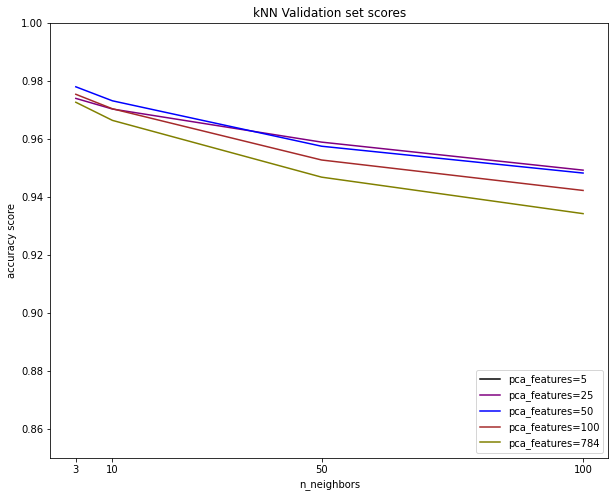

In [251]:
# Here plot score (accuracy) for each model. You can use "plot_scores" function.
knn_eval_scores_to_plot = []
knn_train_scores_to_plot = []
# Example: plot_scores(parameters, scores, "title", "x_label", "y_label"),
for num_features in output_dimension_values:
    num_features_params_eval = {}
    num_features_params_train = {}
    for n_neighbors in n_neighbors_values:
        param = KNN_Param(n_neighbors=n_neighbors, n_features=num_features)
        num_features_params_eval[n_neighbors] = knn_prediction_scores[param]
        num_features_params_train[n_neighbors] = knn_train_scores[param]
    knn_eval_scores_to_plot.append((list(num_features_params_eval.keys()), list(num_features_params_eval.values()), 
                    f"pca_features={num_features}"))
    knn_train_scores_to_plot.append((list(num_features_params_train.keys()), list(num_features_params_train.values()), 
                f"pca_features={num_features}"))

# You can see an example in the follow.
# Note that the visualizations/plots provided are just simple examples/illustrations. 
# We encourage more informative and alternate methods to present results.
#
plot_all_scores(knn_eval_scores_to_plot, x_label="n_neighbors", y_label="accuracy score", title="kNN Validation set scores")

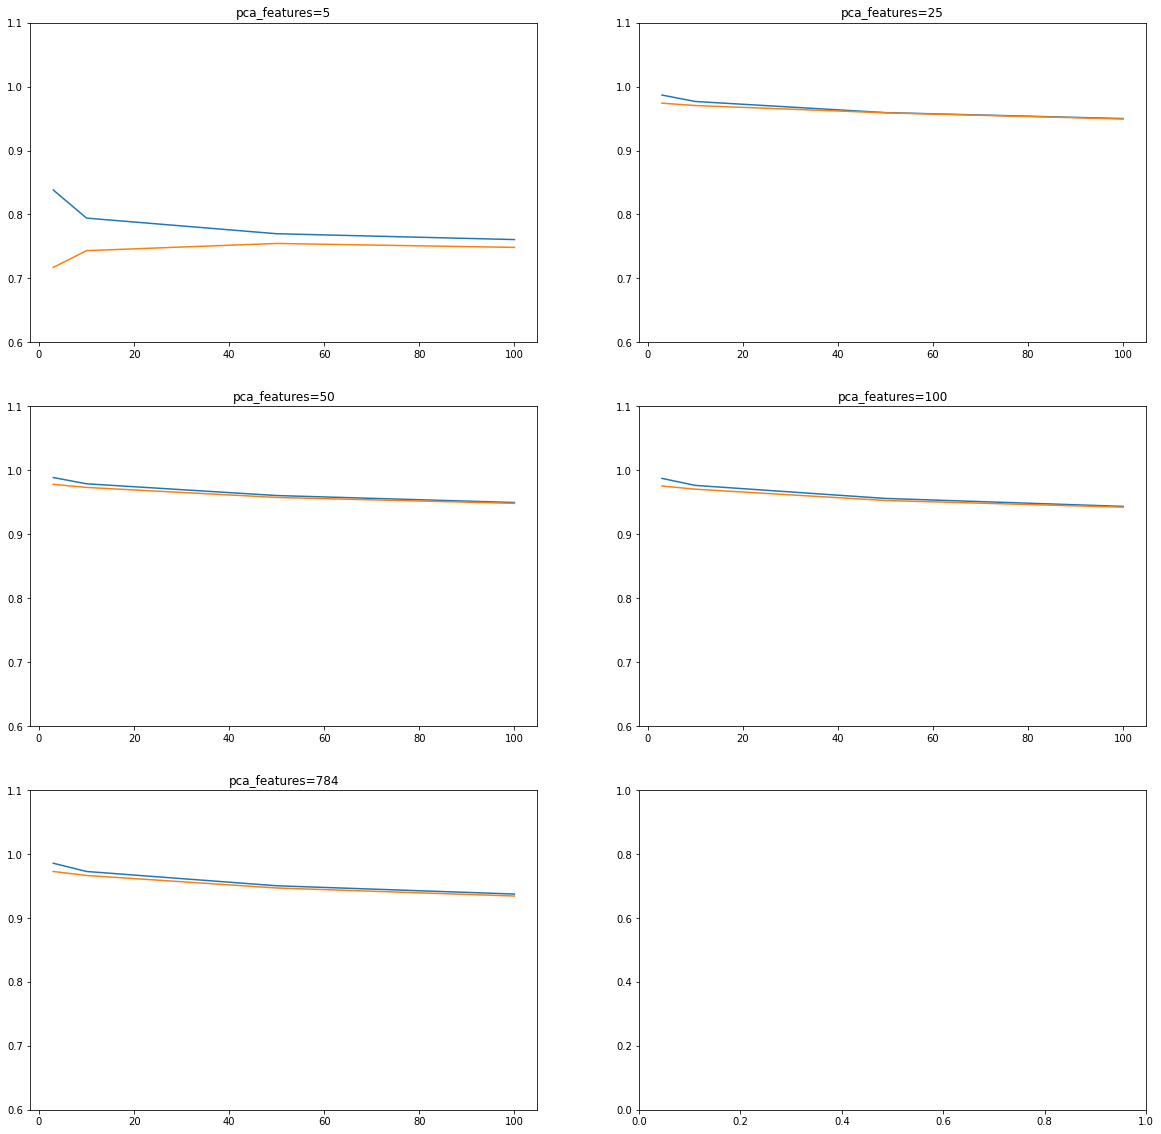

In [256]:
plot_train_eval_scores(knn_train_scores_to_plot, knn_eval_scores_to_plot, rows=3, cols=2)

In [53]:
start = datetime.datetime.now()
# Here report the score for the best model
best_knn_model = knn_models[KNN_Param(n_neighbors=3, n_features=50)]
y_pred = best_knn_model.predict(pca_eval_outputs[50])
end = datetime.datetime.now()
best_knn_val_score = accuracy_score(y_eval.numpy(), y_pred) 
time_delta = (end - start)
print(f"Accuracy score for best model on validation set: {best_knn_val_score*100}% with execution time: {time_delta.total_seconds()} seconds")

Accuracy score for best model on validation set: 97.8% with execution time: 12.752134 seconds


In [56]:
start = datetime.datetime.now()
# Here report the score for the best model
best_knn_model = knn_models[KNN_Param(n_neighbors=3, n_features=50)]
y_pred = best_knn_model.predict(pca_eval_outputs[50])
end = datetime.datetime.now()
best_knn_test_score = accuracy_score(y_eval.numpy(), y_pred) 
time_delta = (end - start)
print(f"Accuracy score for best model on test set: {best_knn_test_score*100}% with execution time: {time_delta.total_seconds()} seconds")

Accuracy score for best model on test set: 96.59% with execution time: 14.783863 seconds


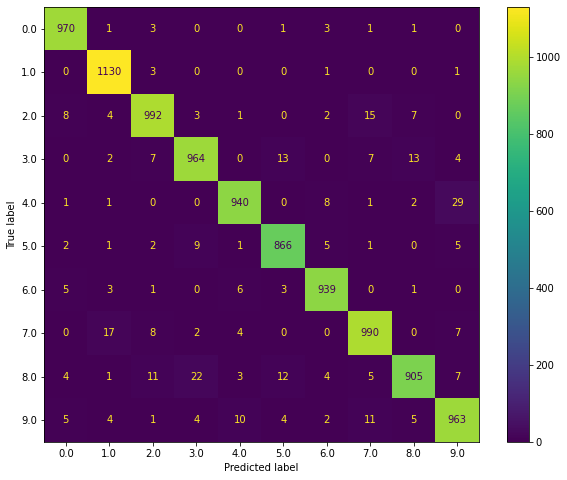

In [283]:
## Analyzing fine-grained accuracy scores per label using confusion matrix 
## on test set
plot_confusion_matrix(best_knn_model, pca_eval_outputs[50], y_eval.numpy());

In [284]:
## finally inspecting the classification report for other metrics like precision, recall and f1-score
print(classification_report(y_eval.numpy(), y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       980
         1.0       0.97      1.00      0.98      1135
         2.0       0.96      0.96      0.96      1032
         3.0       0.96      0.95      0.96      1010
         4.0       0.97      0.96      0.97       982
         5.0       0.96      0.97      0.97       892
         6.0       0.97      0.98      0.98       958
         7.0       0.96      0.96      0.96      1028
         8.0       0.97      0.93      0.95       974
         9.0       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



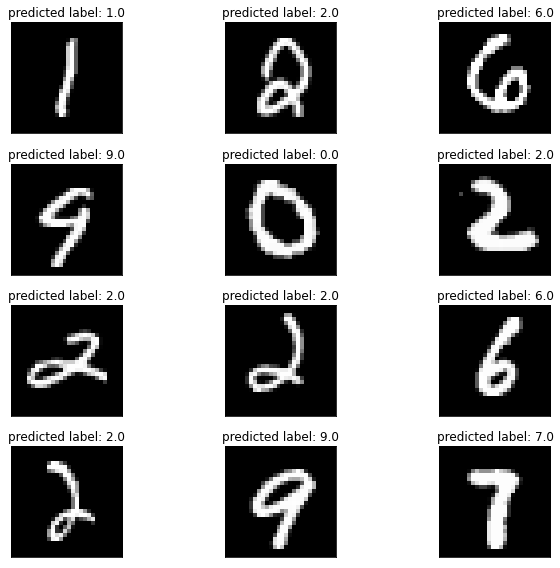

In [285]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)
vis_predictions(x_eval.numpy(), y_pred, len(y_pred))

#### Accuracy on model with 784-dimensional original test dataset

In [286]:
start = datetime.datetime.now()
# Here report the score for the best model
full_knn_model = knn_models[KNN_Param(n_neighbors=3, n_features=784)]
y_pred = full_knn_model.predict(pca_eval_outputs[784])
end = datetime.datetime.now()
time_delta = (end - start)
full_knn_test_score = accuracy_score(y_eval.numpy(), y_pred) 
print(f"Accuracy score for best model: {full_knn_test_score*100}% with execution time: {time_delta.total_seconds()} seconds")

Accuracy score for best model: 96.81% with execution time: 404.889955 seconds


### 2.1.6: Summary

Summarize your findings:
 * **Which hyper-parameters were important and how did they influence your results?** <br/>
 The `k` was the most critical hyperparameter which corresponds to number of neighbors to consider while doing the prediction at inference time. As the value of k increased the bias of models increased as evident from train/validation plots both train and validation accuracy scores decreased. The optimal value we observed for `k` was 3.
 * **What were other design choices you faced?** <br/>
 We also considered dimensionality reduction using PCA as kNN classifiers prone to suffer from curse of dimensionality with high dimensional data and also the inference times also increase in increase in the input dimension of data and hence we tried different values of principal components with PCA. We observed as we increased the number principal components from `5` the accuracy scores increased however after reaching the principal components of `50` there was no gains in accuracy scores. Since there subsequent principal components explained negligible amount of variance in the data.
 * **Any other interesting insights...** <br/>
 We ran small experiment to show the inference time speed up when using dimensionality reduction while having negligible drop in test set accuracy of only `0.22%` whereas the prediction time on test set for model with 50 features was `approx. 15 seconds` whereas the model with 784 input dimensions took `approx. 405 seconds` to predict the same test set of size 10,000 test examples. This is an interesting insight in situations where inference speed is critical and computational resources are limited, PCA based reduced features can really boost inference speed of model.

# 2.2: Model [M2]: Random Forest (25 points)
Random Forest Classifier is an ensemble learning technique which uses multiple decision trees to classify samples. Moreover, while training the train dataset is divided into sub-datasets and using averaging techniques conntrols overfitting the train dataset. During inference of the classification task the output is predicted by taking the majority vote on predicted class by the sub-trees of the random forest. 

We chose this method since it inherently performs feature importance while creating sub-trees, and uses collection of sub-classifiers (decision trees) when making the predictions. Also,  empirically, it follows the rule of thumb as the number of trees increase the performance increases and predictions become more stable. Finally, it's hyperparameters are intuitive to understand which makes this algorithm easy to understand to train and tune hyperparameters.




### 2.2.1: Hyper-parameters

Define hyper-parameters for your method here

In [37]:
"""Flag to determine whether to train new models or load pre-trained models from disk"""
is_load_rf_models = True

"""refers to number of tree estimators in the random forest"""
n_trees_values = [10, 100, 200, 400, 600] 
max_depth_values = [10, 20]   
max_features_values = [100, 392, 'auto']
min_samples_split_values = [2, 4]

test_set ='val' #'val'  #  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation

if test_set == 'test':
    x_trainval_idxs = np.array([idx for idx in range(len(x_trainval))])
    train_idxs, val_idxs, _, _ = train_test_split(x_trainval_idxs, x_trainval_idxs, test_size=0.20, 
                                                        random_state=random_seed)
    x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test

### 2.2.2: Data Preprocessing


In [38]:
## flattening the datasets
x_train_flat = flatten_input_pixels(x_train)
x_eval_flat = flatten_input_pixels(x_eval)

## double check the dimensions of flattened sets
x_train_flat.shape, x_eval_flat.shape

((60000, 784), (10000, 784))

### 2.2.3: Model

Define your model here (all hyper-parameters in 2.1.1)

In [23]:
rf_models = {}
from collections import namedtuple

RF_Param = namedtuple('RF_Param', ['n_trees', "max_features", "max_depth", "min_samples_split"])

def init_rf_models():
    for num_trees in n_trees_values:
        for max_depth in max_depth_values:
            for max_features in max_features_values:
                for min_samples_split in min_samples_split_values:
                    # defining the model
                    param = RF_Param(n_trees=num_trees, max_depth=max_depth, 
                                     max_features=max_features, min_samples_split=min_samples_split)
                    rf_models[param] = RandomForestClassifier(n_estimators=param.n_trees, 
                                                              max_depth=param.max_depth, max_features=param.max_features, 
                                                              min_samples_split=param.min_samples_split, n_jobs=-1)

### 2.2.4: Fit Model


In [24]:
# fit the model
def train_rf_models():
    for model_name in tqdm(list(rf_models.keys())):
        rf_models[model_name] = rf_models[model_name].fit(x_train_flat, y_train)

In [25]:
# saving the trained models
def save_rf_models():
    for model_name in tqdm(list(rf_models.keys())):
        file_name = f"models/rf_{str(model_name)}_trees.pickle"
        with open(file_name, "wb") as file:
            pickle.dump(rf_models[model_name], file, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
# load the trained models
def load_rf_models():
    print("loading models")
    for num_trees in tqdm(n_trees_values):
        for max_depth in max_depth_values:
            for max_features in max_features_values:
                for min_samples_split in min_samples_split_values:
                    # defining the model
                    param = RF_Param(n_trees=num_trees, max_depth=max_depth, 
                                     max_features=max_features, min_samples_split=min_samples_split)
                    file_name = f"models/rf_{str(param)}_trees.pickle"
                    with open(file_name, 'rb') as file:
                        rf_models[param] = pickle.load(file)

In [27]:
if is_load_rf_models:
    load_rf_models()
else:
    init_rf_models()
    train_rf_models()
    save_rf_models()  

  0%|          | 0/5 [00:00<?, ?it/s]

loading models


100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


### 2.2.5: Evaluation

Evaluate your model.
  * Evaluate models with different parameters 
  * Plot score (accuracy) for each model using "plot_scores" function
  * Report the score for the best model
  * Use "vis_predictions" function to visualize few examples of test/validation set with the corresponding predictions


In [28]:
rf_train_scores = {}
for model_name in tqdm(list(rf_models.keys())):
    y_pred = rf_models[model_name].predict(x_train_flat)
    rf_train_scores[model_name] = accuracy_score(y_train.numpy(), y_pred) 

100%|██████████| 60/60 [02:07<00:00,  2.13s/it]


In [29]:
rf_prediction_scores = {}
for model_name in tqdm(list(rf_models.keys())):
    y_pred = rf_models[model_name].predict(x_eval_flat)
    rf_prediction_scores[model_name] = accuracy_score(y_eval.numpy(), y_pred) 

100%|██████████| 60/60 [00:42<00:00,  1.41it/s]


In [30]:
rf_val_parameter_scores = {key.n_trees:rf_prediction_scores[key] for key in rf_prediction_scores}
rf_train_parameter_scores = {key.n_trees:rf_train_scores[key] for key in rf_train_scores}

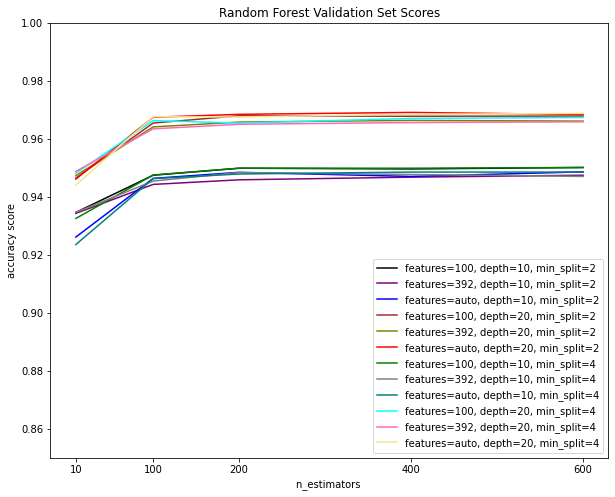

In [31]:
# Here plot score (accuracy) for each model. You can use "plot_scores" function.
eval_scores_to_plot = []
train_scores_to_plot = []
# Example: plot_scores(parameters, scores, "title", "x_label", "y_label"),
for min_samples_split in min_samples_split_values:
        for max_depth in max_depth_values:
            for max_features in max_features_values:
                num_tree_params_eval = {}
                num_tree_params_train = {}
                for num_trees in n_trees_values:
                    # defining the model
                    param = RF_Param(n_trees=num_trees, max_depth=max_depth, 
                                     max_features=max_features, min_samples_split=min_samples_split)
                    num_tree_params_eval[num_trees] = rf_prediction_scores[param]
                    num_tree_params_train[num_trees] = rf_train_scores[param]
                eval_scores_to_plot.append((list(num_tree_params_eval.keys()), list(num_tree_params_eval.values()), 
                            f"features={max_features}, depth={max_depth}, min_split={min_samples_split}"))
                train_scores_to_plot.append((list(num_tree_params_train.keys()), list(num_tree_params_train.values()), 
                            f"features={max_features}, depth={max_depth}, min_split={min_samples_split}"))
# You can see an example in the follow.
# Note that the visualizations/plots provided are just simple examples/illustrations. 
# We encourage more informative and alternate methods to present results.
#

plot_all_scores(eval_scores_to_plot, title='Random Forest Validation Set Scores', x_label='n_estimators ', y_label='accuracy score')


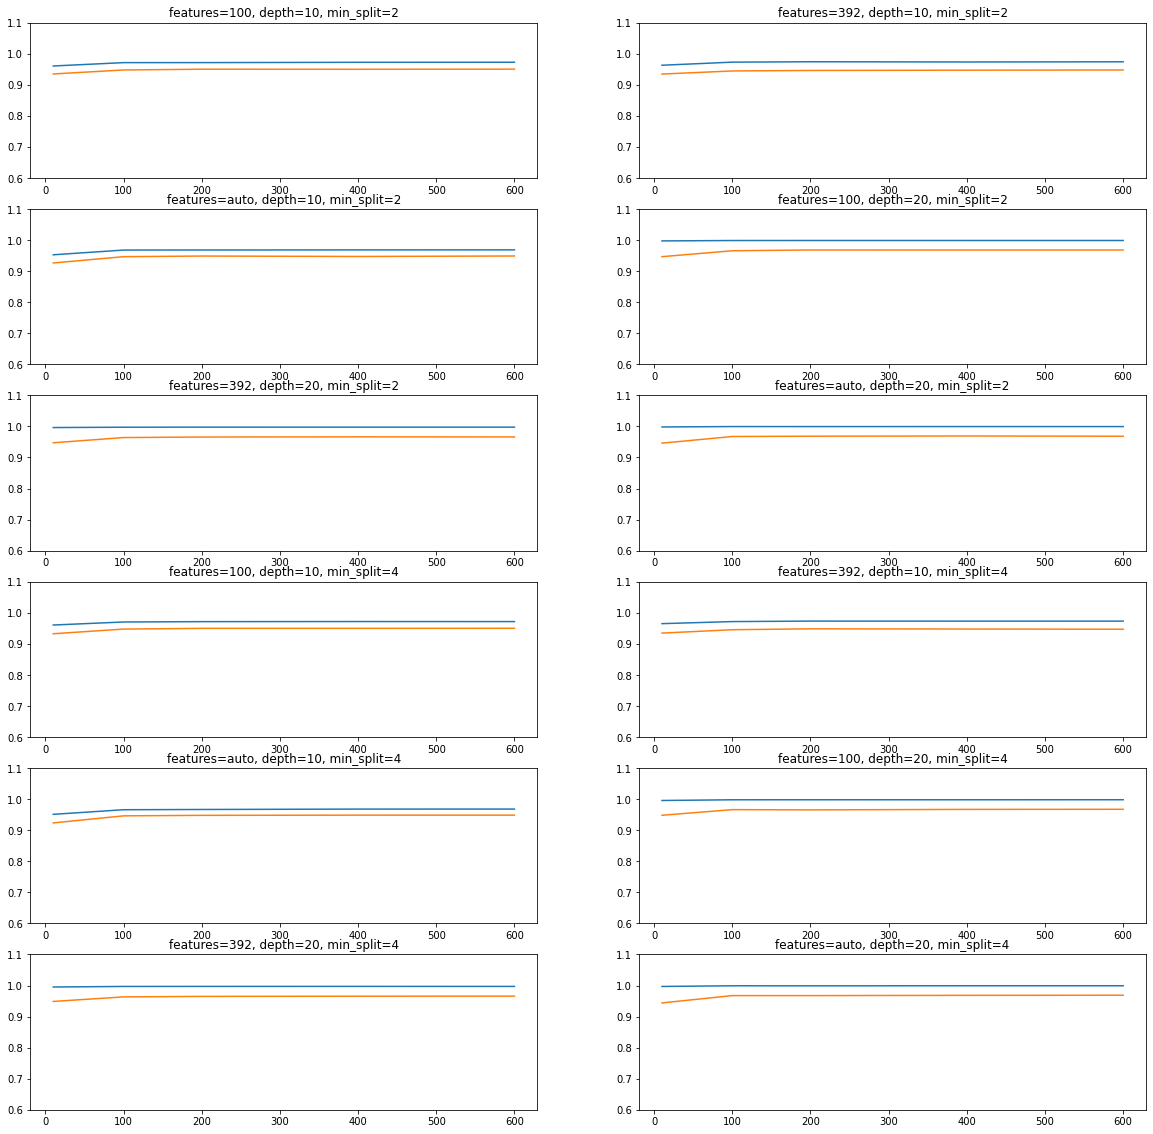

In [32]:
plot_train_eval_scores(train_scores_to_plot, eval_scores_to_plot, rows=6, cols=2)

In [35]:
# Here report the score for the best model
best_rf_model = rf_models[RF_Param(n_trees=400, max_features='auto', max_depth=20, min_samples_split=4)]
y_pred = best_rf_model.predict(x_eval_flat)
rf_best_val_score = accuracy_score(y_eval.numpy(), y_pred) 
print(f"Accuracy score for best model on validation set: {rf_best_val_score*100}%")

Accuracy score for best model on validation set: 96.85000000000001%


In [39]:
# Here report the score for the best model
best_rf_model = rf_models[RF_Param(n_trees=400, max_features='auto', max_depth=20, min_samples_split=4)]
y_pred = best_rf_model.predict(x_eval_flat)
rf_best_test_score = accuracy_score(y_eval.numpy(), y_pred) 
print(f"Accuracy score for best model on test set: {rf_best_test_score*100}%")

Accuracy score for best model on test set: 96.87%


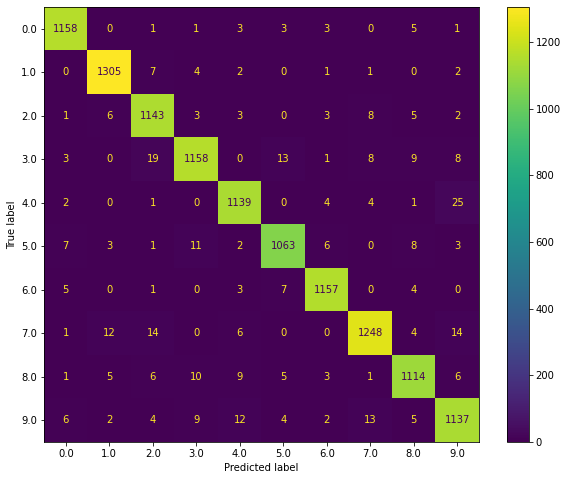

In [131]:
## Analyzing fine-grained accuracy scores per label using confusion matrix on test set
plot_confusion_matrix(best_rf_model, x_eval_flat, y_eval.numpy());

In [132]:
## finally inspecting the classification report for other metrics like precision, recall and f1-score 
## on Test set
print(classification_report(y_eval.numpy(), y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1175
         1.0       0.98      0.99      0.98      1322
         2.0       0.95      0.97      0.96      1174
         3.0       0.97      0.95      0.96      1219
         4.0       0.97      0.97      0.97      1176
         5.0       0.97      0.96      0.97      1104
         6.0       0.98      0.98      0.98      1177
         7.0       0.97      0.96      0.97      1299
         8.0       0.96      0.96      0.96      1160
         9.0       0.95      0.95      0.95      1194

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



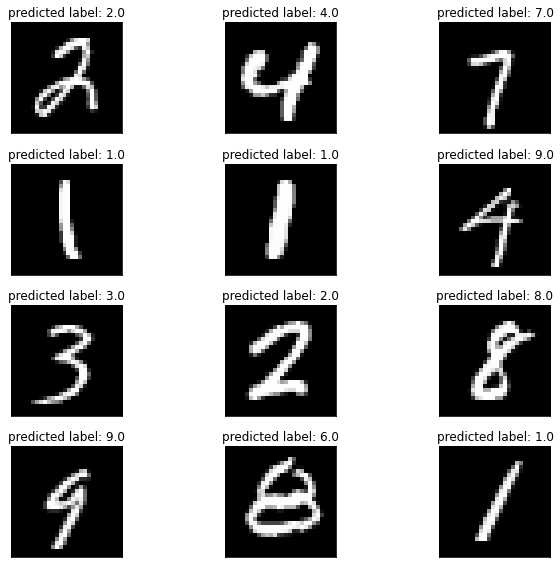

In [133]:
# Visualize the predictions on test set
# Example: vis_predictions(x_eval, y_pred, size_of_data)
vis_predictions(x_eval.numpy(), y_pred, len(y_pred))

### 2.2.6: Summary

Summarize your findings:
 * **Which hyper-parameters were important and how did they influence your results?** <br/>
 The most important hyper-parameter is `n_estimators` which means the number of sub-trees so increasing the number of trees resulted in increase in accuracy scores, however, after reaching `400` sub-trees the performance gain becomes neglible. Secondly, the hyperprameter `max_features` also influenced the accuracy scores of roughly `2%`, the best value for `max_features='auto'` which corresponds to `sqrt(n_features) around 27 features`. This means the max number of features the classifier can use when looking for the best split of sub-samples is `sqrt(n_features)`. Hence, using large of number max features for the best split during training didn't necessarily result in a high accuracy score and here the default value worked the best.
 * **What were other design choices you faced?** <br/>
Another important design choice we made was to not use dimensionality reduction since Random Forest Classifier implicitly performs feature importance using out-of-bag error. As algorithm automatically determines which features to use in each split based on variance in data explained by that feature. Hence, limiting the input feature space before inputting to the classifier may have resulted in lower performance.
 * **Any other interesting insights...** <br/>
 The top-2 best performing models were using 400 and 600 estimators with other hyperparameters roughly identical. We observed that model with 400 estimators performed roughly similar to model with 600 trees. Since, using having 600 means inference time would be more than model with 400 trees, so we chose model with 400 trees without compromising on performance while optimizing the inference time.

# 2.3: Model [M3] (Neural Networks): Convolution Neural Networks (25 points)



In Classification/Recogition problems, decision making is done in the classification phase. For recognizing the characters, the extracted features are used. Different classifiers like
Convolution Neural Networks are used. The classifiers sorts the given input feature with reserved pattern and find the best matching class for input.
Such classification or recognition problems like hand written digits using convolution neural network are already being tested and verified. The reasons why CNN works so well is because:
- CNN acchitecture can contain one or more than one convolutional layer which makes the classifer flexible for dofferent recognitons task, convolutional layer uses convolutional operation on the i/p.
- CNN nework can use variation of multilayer perceptrons.
- CNN layers can either be completely interconnected or pooled and before passing the result to the next layer.
- Pooling layer reduce the dimensions of data by combining the output of neuron cluster at one layer into a single neuron in the next layer.
- CNNs also show great result in semantic parsing and paraphrase detection.
- Adaptive Learning
- Real Time Operation: NN computations may be carried out in parallel, and special hardware devices are being designed and manufactured which take advantage of this capability.

### 2.3.1: Data Preprocessing


In [5]:

def _get_data(DATA_PATH, TRAIN_BATCH_SIZE, TEST_BATCH_SIZE):
    try:
        """
        This method is created to split the MNIST data into training, validation and testing set accordingly 
        and load it into dataloaders. Also, to specify any transformations required to perform on the data. 
        As well as this method is being called multiple times in hyper parameter tuning where different batch 
        sizes are being tested
        ...

        Parameters
        ----------
        DATA_PATH : str
            specifies the path directory where dataset will be downloaded
        TRAIN_BATCH_SIZE : int
            specifies the batch size in the training loader
        TEST_BATCH_SIZE : int
            specifies the batch size in the training loader
            
        Returns
        -------
        train_loader, validation_loader, test_loader with the specified batch sizes 
            
        """
        tranformations = transforms.Compose([transforms.ToTensor(), 
                                            # transforms.Normalize((0.5,), (0.5,)),
                                          #    transforms.RandomAffine(
                                          #     degrees=35,
                                          #     translate=(0.2, 0.2),
                                          #     scale=(0.85, 1.15),
                                          #     # resample=PIL.Image.BICUBIC
                                          # ),
                                            ])
        
        mnist_training_dataset = datasets.MNIST(root=DATA_PATH+'train', train=True, download=True, transform=tranformations)
        mnist_testing_dataset = datasets.MNIST(root=DATA_PATH+'test', train=False, download=True, transform=tranformations)
        
        training_dataset, validation_dataset = random_split(mnist_training_dataset, [int(0.8*len(mnist_training_dataset)), int(0.2*len(mnist_training_dataset))])
        
        train_loader = DataLoader(training_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
        validation_loader = DataLoader(training_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(mnist_testing_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
        
        return train_loader, validation_loader, test_loader
    
    except Exception as e:
        print('Unable to get data due to ', e)


### 2.3.2: Model

Define your model here

In [6]:

class CNN_Network(nn.Module):
    def __init__(self, model_params):
        """
        This class is created to specify the Convolutional Neural Network on which MNIST dataset is trained on, 
        validated and later tested. 
        It consist of one input layer, one output layer can consist of multiple hidden layers all of which is 
        specified by the user as provided through model_paramaters
        Size of the kernel, stride and padding can also be adjusted by the user as provided through model_paramaters
        ...

        Parameters
        ----------
        model_params : dictionary
            provides the model with the required input size, hidden layers and output size
            
            model_params = {
            'INPUT_SIZE' : int,
            'HIDDEN_LAYERS' : list(int),
            'OUTPUT_SIZE' : int,
            'KERNEL' : int,
            'STRIDE' : int,
            'PADDING' : int
        }
        """
        try:
            super(CNN_Network, self).__init__()
            
            layers = []
            
            for input_channel, out_channel in zip([model_params['INPUT_SIZE']] + model_params['HIDDEN_LAYERS'][:-1], 
                                                     model_params['HIDDEN_LAYERS'][:len(model_params['HIDDEN_LAYERS'])]):
                layers.append(nn.Conv2d(input_channel, out_channel, model_params['KERNEL'], model_params['STRIDE'], model_params['PADDING'], bias=True))
                layers.append(nn.MaxPool2d(2, 2))
                layers.append(nn.ReLU())
            layers.append(nn.Flatten(1))      
            layers.append(nn.Linear(model_params['HIDDEN_LAYERS'][-1], model_params['OUTPUT_SIZE'], bias=True))

            self.layers = nn.Sequential(*layers)
        
        except Exception as e:
            print('initializing failed due to ', e)
    
    def forward(self, x):
        try:
            return self.layers(x)
        
        except Exception as e:
            print('forward pass failed due to ', e)
      

### 2.3.3: Training Method

In [7]:
        
def _network_training(model, train_loader, validation_loader, criterion, optimizer, training_params, set_device, tuning=False):
    try:            
        best_accuracy = 0
        training_loss_history = []
        validation_loss_history = []
        training_acc_history = []
        validation_acc_history = []
        
        for epoch in range(0, training_params['NUM_EPOCHS']):
            model.train()
            train_loss_scores = []
            training_acc_scores = []
            correct_predictions = 0
            
            for batch_index, (images, targets) in enumerate(train_loader):
                images = images.to(set_device)
                targets = targets.to(set_device)
                
                outputs = model(images)
                loss = criterion(outputs, targets)
                train_loss_scores.append(loss.item())
                
                _, preds = torch.max(outputs, 1)
                correct_predictions = (preds==targets).sum().item()
                training_acc_scores.append(correct_predictions/targets.shape[0])
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if not tuning:
                    if (batch_index+1) % 100 == 0:
                        print(f"Epoch : [{epoch+1}/{training_params['NUM_EPOCHS']}] | Step : [{batch_index+1}/{len(train_loader)}] | Loss : {loss.item()} ")
            
            training_loss_history.append((sum(train_loss_scores)/len(train_loss_scores)))
            training_acc_history.append((sum(training_acc_scores)/len(training_acc_scores))*100)      
            print(f'Epoch : {epoch+1} | Loss : {training_loss_history[-1]} | Training Accuracy : {training_acc_history[-1]}%')
       
            model.eval()
            with torch.no_grad():
                correct_predictions = 0
                validation_acc_scores = []
                validation_loss_scores = []

                for images, targets in iter(validation_loader):
                    images = images.to(set_device)
                    targets = targets.to(set_device)
                                
                    outputs = model(images)
                    loss = criterion(outputs, targets)
                    validation_loss_scores.append(loss.item())

                    _, preds = torch.max(outputs, 1)
                    correct_predictions = (preds == targets).sum().item()
                    validation_acc_scores.append(correct_predictions/targets.shape[0])
                
                validation_loss_history.append((sum(validation_loss_scores)/len(validation_loss_scores)))
                validation_acc_history.append((sum(validation_acc_scores)/len(validation_acc_scores))*100)
                print(f'Epoch {epoch+1} | Validation Accuracy {validation_acc_history[-1]}%')
                
                if not tuning: 
                    if validation_acc_history[-1]>best_accuracy:
                        best_accuracy = validation_acc_history[-1]
                        print('Saving the model...')
                        torch.save(model.state_dict(), f"Accuracy_{best_accuracy}_batchsize_{training_params['TRAIN_BATCH_SIZE']}_lr_{training_params['LEARNING_RATE']}.ckpt")
        if tuning:
            return validation_acc_history
        else:
            return training_loss_history, validation_loss_history, training_acc_history, validation_acc_history
    
    except Exception as e:
        print('Error occured in training method = ', e)
        

### 2.3.4: Hyper-parameter Tuning

Define hyper-parameters for your method here

In [84]:

def _hyper_parameter_tuning(trial):
        
    """
    This method is created to perform hyperparameter tuning on the trial setting made of different combinations of hyper parameters. 
    ...

    HyperParameters
    ----------
    
    hyper_paramaters = {
        'TRAIN_BATCH_SIZE' : (16, 32, 64)),
        'LEARNING_RATE' : range(0.001, 0.01),
        'OPTIMIZER': "Adam", "RMSprop", "SGD",
        'NUM_EPOCHS' : range(5, 10)
    }
        """  
    
    
    DATA_PATH = 'D:/Repos/MLCS_Project_Assignments/'
    set_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    hyper_paramaters = {
        'TRAIN_BATCH_SIZE' :  trial.suggest_categorical('TRAIN_BATCH_SIZE', (16, 32, 64)),
        'LEARNING_RATE' : trial.suggest_loguniform('LEARNING_RATE', 0.001, 0.01),
        'OPTIMIZER': trial.suggest_categorical("OPTIMIZER", ["Adam", "RMSprop", "SGD"]),
        'NUM_EPOCHS' : trial.suggest_categorical("NUM_EPOCHS", [3, 5, 10])
    }
    
    model_params = {
        'INPUT_SIZE' : 1,
        'HIDDEN_LAYERS' : [140, 100, 70, 10],
        'OUTPUT_SIZE' : 10,
        'KERNEL' : 3,
        'STRIDE' : 1,
        'PADDING' : 1
    }
    
    train_loader, validation_loader, _ = _get_data(DATA_PATH, hyper_paramaters['TRAIN_BATCH_SIZE'], 1000)
    model = CNN_Network(model_params).to(set_device)
    criterion = nn.CrossEntropyLoss().to(set_device)
    optimizer = getattr(optim, hyper_paramaters['OPTIMIZER'])(model.parameters(), lr=hyper_paramaters['LEARNING_RATE'])
    
    acc = _network_training(model, train_loader, validation_loader, criterion, optimizer, hyper_paramaters, set_device, tuning=True)
    return np.mean(acc)

with warnings.catch_warnings(record=True):
    analysis_study = optuna.create_study(direction='maximize')
    analysis_study.optimize(_hyper_parameter_tuning, n_trials=20)
    

[I 2021-11-07 05:16:58,216] A new study created in memory with name: no-name-23935f30-f71e-4257-be03-756c9db9efeb


Epoch : 1 | Loss : 2.304179297129313 | Training Accuracy : 10.960416666666667%
Epoch 1 | Validation Accuracy 11.143749999999999%
Epoch : 2 | Loss : 2.301535239537557 | Training Accuracy : 11.143749999999999%
Epoch 2 | Validation Accuracy 11.143749999999999%
Epoch : 3 | Loss : 2.3015060447057087 | Training Accuracy : 11.05%


[I 2021-11-07 05:17:40,840] Trial 0 finished with value: 11.143749999999999 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.002755198694996754, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 3}. Best is trial 0 with value: 11.143749999999999.


Epoch 3 | Validation Accuracy 11.143749999999999%
Epoch : 1 | Loss : 0.39101620843758184 | Training Accuracy : 87.63541666666667%
Epoch 1 | Validation Accuracy 96.22500000000001%
Epoch : 2 | Loss : 0.09769182144043347 | Training Accuracy : 97.09791666666666%
Epoch 2 | Validation Accuracy 98.07291666666667%
Epoch : 3 | Loss : 0.06916257038898765 | Training Accuracy : 97.95%


[I 2021-11-07 05:18:23,622] Trial 1 finished with value: 97.54583333333335 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0011961639492621076, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 3}. Best is trial 1 with value: 97.54583333333335.


Epoch 3 | Validation Accuracy 98.33958333333334%
Epoch : 1 | Loss : 2.059157360136509 | Training Accuracy : 28.464583333333334%
Epoch 1 | Validation Accuracy 60.21041666666667%
Epoch : 2 | Loss : 0.5119939834487935 | Training Accuracy : 83.71041666666666%
Epoch 2 | Validation Accuracy 90.09166666666667%
Epoch : 3 | Loss : 0.22218368739324312 | Training Accuracy : 93.26666666666667%
Epoch 3 | Validation Accuracy 95.01875%
Epoch : 4 | Loss : 0.15077586717849287 | Training Accuracy : 95.41875%
Epoch 4 | Validation Accuracy 96.27916666666667%
Epoch : 5 | Loss : 0.11964037219621242 | Training Accuracy : 96.38333333333333%
Epoch 5 | Validation Accuracy 97.00625000000001%
Epoch : 6 | Loss : 0.10188419142873803 | Training Accuracy : 96.92708333333333%
Epoch 6 | Validation Accuracy 97.44166666666668%
Epoch : 7 | Loss : 0.08794079986767611 | Training Accuracy : 97.29791666666667%
Epoch 7 | Validation Accuracy 97.76041666666667%
Epoch : 8 | Loss : 0.0794872301830134 | Training Accuracy : 97.49375

[I 2021-11-07 05:21:44,869] Trial 2 finished with value: 92.79729166666667 and parameters: {'TRAIN_BATCH_SIZE': 16, 'LEARNING_RATE': 0.0027962666016073225, 'OPTIMIZER': 'SGD', 'NUM_EPOCHS': 10}. Best is trial 1 with value: 97.54583333333335.


Epoch 10 | Validation Accuracy 98.17708333333334%
Epoch : 1 | Loss : 0.39197906765528023 | Training Accuracy : 87.14583333333333%
Epoch 1 | Validation Accuracy 93.65%
Epoch : 2 | Loss : 0.15818193308031187 | Training Accuracy : 95.35416666666666%
Epoch 2 | Validation Accuracy 96.03541666666666%
Epoch : 3 | Loss : 0.1347553477990441 | Training Accuracy : 96.01041666666667%
Epoch 3 | Validation Accuracy 96.50208333333333%
Epoch : 4 | Loss : 0.13071194098501776 | Training Accuracy : 96.13333333333334%
Epoch 4 | Validation Accuracy 96.22708333333333%
Epoch : 5 | Loss : 0.12367478623163576 | Training Accuracy : 96.31041666666667%
Epoch 5 | Validation Accuracy 94.97916666666667%
Epoch : 6 | Loss : 0.11719782588508679 | Training Accuracy : 96.46458333333334%
Epoch 6 | Validation Accuracy 97.2375%
Epoch : 7 | Loss : 0.11789436218503396 | Training Accuracy : 96.46666666666667%
Epoch 7 | Validation Accuracy 97.4375%
Epoch : 8 | Loss : 0.11405110611223306 | Training Accuracy : 96.56458333333333%


[I 2021-11-07 05:24:37,297] Trial 3 finished with value: 96.34604166666665 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.007550165462123887, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 10}. Best is trial 1 with value: 97.54583333333335.


Epoch 10 | Validation Accuracy 97.32291666666667%
Epoch : 1 | Loss : 2.3035507791042327 | Training Accuracy : 10.929166666666665%
Epoch 1 | Validation Accuracy 11.225%
Epoch : 2 | Loss : 2.3025377770264943 | Training Accuracy : 10.9%
Epoch 2 | Validation Accuracy 11.225%
Epoch : 3 | Loss : 2.3025709873835245 | Training Accuracy : 11.079166666666666%


[I 2021-11-07 05:25:50,087] Trial 4 finished with value: 11.225 and parameters: {'TRAIN_BATCH_SIZE': 16, 'LEARNING_RATE': 0.005727455672275507, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 3}. Best is trial 1 with value: 97.54583333333335.


Epoch 3 | Validation Accuracy 11.225%
Epoch : 1 | Loss : 1.3537062970896563 | Training Accuracy : 54.7625%
Epoch 1 | Validation Accuracy 88.5125%
Epoch : 2 | Loss : 0.25679831089576083 | Training Accuracy : 91.89583333333333%
Epoch 2 | Validation Accuracy 94.71875%
Epoch : 3 | Loss : 0.15338908387813718 | Training Accuracy : 95.25833333333334%
Epoch 3 | Validation Accuracy 96.14166666666667%
Epoch : 4 | Loss : 0.11578738342225552 | Training Accuracy : 96.34583333333333%
Epoch 4 | Validation Accuracy 97.18541666666667%
Epoch : 5 | Loss : 0.0949144898361216 | Training Accuracy : 97.1125%


[I 2021-11-07 05:27:09,339] Trial 5 finished with value: 94.835 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.009403605354183161, 'OPTIMIZER': 'SGD', 'NUM_EPOCHS': 5}. Best is trial 1 with value: 97.54583333333335.


Epoch 5 | Validation Accuracy 97.61666666666666%
Epoch : 1 | Loss : 2.314010579744975 | Training Accuracy : 9.85%
Epoch 1 | Validation Accuracy 9.85%
Epoch : 2 | Loss : 2.2848414567311606 | Training Accuracy : 15.558333333333332%
Epoch 2 | Validation Accuracy 20.366666666666667%
Epoch : 3 | Loss : 2.17677313264211 | Training Accuracy : 25.514583333333334%
Epoch 3 | Validation Accuracy 33.99791666666667%
Epoch : 4 | Loss : 1.5931104249159496 | Training Accuracy : 51.231249999999996%
Epoch 4 | Validation Accuracy 68.21666666666667%
Epoch : 5 | Loss : 0.795451336979866 | Training Accuracy : 75.74375%
Epoch 5 | Validation Accuracy 82.90833333333333%
Epoch : 6 | Loss : 0.47945929775635404 | Training Accuracy : 85.25208333333333%
Epoch 6 | Validation Accuracy 88.25208333333333%
Epoch : 7 | Loss : 0.3511578758160273 | Training Accuracy : 89.49583333333334%
Epoch 7 | Validation Accuracy 90.61666666666667%
Epoch : 8 | Loss : 0.2811538321773211 | Training Accuracy : 91.84791666666666%
Epoch 8 | 

[I 2021-11-07 05:29:25,689] Trial 6 finished with value: 67.56395833333333 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0026704203418296078, 'OPTIMIZER': 'SGD', 'NUM_EPOCHS': 10}. Best is trial 1 with value: 97.54583333333335.


Epoch 10 | Validation Accuracy 94.50833333333334%
Epoch : 1 | Loss : 2.6983740218480428 | Training Accuracy : 10.9875%
Epoch 1 | Validation Accuracy 11.320833333333333%
Epoch : 2 | Loss : 2.3022956790129343 | Training Accuracy : 11.06875%
Epoch 2 | Validation Accuracy 11.320833333333333%
Epoch : 3 | Loss : 2.3022866211732227 | Training Accuracy : 11.079166666666666%
Epoch 3 | Validation Accuracy 11.320833333333333%
Epoch : 4 | Loss : 2.3022964153289793 | Training Accuracy : 11.13125%
Epoch 4 | Validation Accuracy 11.320833333333333%
Epoch : 5 | Loss : 2.3021667505900063 | Training Accuracy : 11.200000000000001%
Epoch 5 | Validation Accuracy 10.3875%
Epoch : 6 | Loss : 2.3023193775018056 | Training Accuracy : 11.029166666666667%
Epoch 6 | Validation Accuracy 10.183333333333334%
Epoch : 7 | Loss : 2.302290943145752 | Training Accuracy : 11.185416666666667%
Epoch 7 | Validation Accuracy 10.183333333333334%
Epoch : 8 | Loss : 2.3022300098737083 | Training Accuracy : 10.975%
Epoch 8 | Valid

[I 2021-11-07 05:33:12,499] Trial 7 finished with value: 10.845833333333335 and parameters: {'TRAIN_BATCH_SIZE': 16, 'LEARNING_RATE': 0.005877790539272877, 'OPTIMIZER': 'RMSprop', 'NUM_EPOCHS': 10}. Best is trial 1 with value: 97.54583333333335.


Epoch 10 | Validation Accuracy 9.779166666666667%
Epoch : 1 | Loss : 2.302798843383789 | Training Accuracy : 10.85%
Epoch 1 | Validation Accuracy 11.143749999999999%
Epoch : 2 | Loss : 2.3016953948338825 | Training Accuracy : 11.143749999999999%
Epoch 2 | Validation Accuracy 11.143749999999999%
Epoch : 3 | Loss : 2.301674144744873 | Training Accuracy : 11.143749999999999%


[I 2021-11-07 05:33:55,029] Trial 8 finished with value: 11.143749999999999 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.003536166849079699, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 3}. Best is trial 1 with value: 97.54583333333335.


Epoch 3 | Validation Accuracy 11.143749999999999%
Epoch : 1 | Loss : 2.9226662548383078 | Training Accuracy : 11.070833333333335%
Epoch 1 | Validation Accuracy 11.25%
Epoch : 2 | Loss : 2.3024093236923218 | Training Accuracy : 11.018749999999999%
Epoch 2 | Validation Accuracy 10.185416666666667%
Epoch : 3 | Loss : 2.3023584065437315 | Training Accuracy : 10.810416666666667%
Epoch 3 | Validation Accuracy 11.25%
Epoch : 4 | Loss : 2.302333393732707 | Training Accuracy : 10.935416666666667%
Epoch 4 | Validation Accuracy 10.372916666666667%
Epoch : 5 | Loss : 2.3025339180628457 | Training Accuracy : 10.920833333333334%


[I 2021-11-07 05:35:18,028] Trial 9 finished with value: 10.861666666666668 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.008917826015657333, 'OPTIMIZER': 'RMSprop', 'NUM_EPOCHS': 5}. Best is trial 1 with value: 97.54583333333335.


Epoch 5 | Validation Accuracy 11.25%
Epoch : 1 | Loss : 0.35024162014449634 | Training Accuracy : 88.725%
Epoch 1 | Validation Accuracy 96.87916666666668%
Epoch : 2 | Loss : 0.07581856696649145 | Training Accuracy : 97.76875000000001%
Epoch 2 | Validation Accuracy 98.60624999999999%
Epoch : 3 | Loss : 0.051162086794463296 | Training Accuracy : 98.43125%


[I 2021-11-07 05:36:01,790] Trial 10 finished with value: 98.07916666666665 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0010446264658494882, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 3}. Best is trial 10 with value: 98.07916666666665.


Epoch 3 | Validation Accuracy 98.75208333333333%
Epoch : 1 | Loss : 0.37782126349955797 | Training Accuracy : 87.97083333333333%
Epoch 1 | Validation Accuracy 95.57708333333333%
Epoch : 2 | Loss : 0.10045923771585027 | Training Accuracy : 97.13333333333334%
Epoch 2 | Validation Accuracy 98.04375%
Epoch : 3 | Loss : 0.07285431747759381 | Training Accuracy : 97.85000000000001%


[I 2021-11-07 05:36:44,810] Trial 11 finished with value: 97.42708333333333 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.001111090360874761, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 3}. Best is trial 10 with value: 98.07916666666665.


Epoch 3 | Validation Accuracy 98.66041666666666%
Epoch : 1 | Loss : 0.3952507667740186 | Training Accuracy : 86.7%
Epoch 1 | Validation Accuracy 96.42500000000001%
Epoch : 2 | Loss : 0.10452054546773434 | Training Accuracy : 96.92916666666666%
Epoch 2 | Validation Accuracy 97.83541666666666%
Epoch : 3 | Loss : 0.07140091456038257 | Training Accuracy : 97.89166666666667%


[I 2021-11-07 05:37:28,520] Trial 12 finished with value: 97.63194444444446 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0010007077478916657, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 3}. Best is trial 10 with value: 98.07916666666665.


Epoch 3 | Validation Accuracy 98.63541666666666%
Epoch : 1 | Loss : 0.2943712768405676 | Training Accuracy : 90.53541666666666%
Epoch 1 | Validation Accuracy 97.5125%
Epoch : 2 | Loss : 0.0703740080941158 | Training Accuracy : 97.87291666666667%
Epoch 2 | Validation Accuracy 98.5375%
Epoch : 3 | Loss : 0.05030221352633089 | Training Accuracy : 98.51875%


[I 2021-11-07 05:38:13,673] Trial 13 finished with value: 98.37083333333334 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0016766441884033716, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 3}. Best is trial 13 with value: 98.37083333333334.


Epoch 3 | Validation Accuracy 99.0625%
Epoch : 1 | Loss : 0.4094037118802468 | Training Accuracy : 86.96249999999999%
Epoch 1 | Validation Accuracy 95.90833333333333%
Epoch : 2 | Loss : 0.11169280094032487 | Training Accuracy : 96.77291666666666%
Epoch 2 | Validation Accuracy 97.89999999999999%
Epoch : 3 | Loss : 0.07505423439263055 | Training Accuracy : 97.82499999999999%


[I 2021-11-07 05:38:57,006] Trial 14 finished with value: 97.41111111111111 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.001692117607257038, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 3}. Best is trial 13 with value: 98.37083333333334.


Epoch 3 | Validation Accuracy 98.425%
Epoch : 1 | Loss : 2.314354742685954 | Training Accuracy : 10.8625%
Epoch 1 | Validation Accuracy 11.239583333333334%
Epoch : 2 | Loss : 2.3015618960062665 | Training Accuracy : 11.239583333333334%
Epoch 2 | Validation Accuracy 11.239583333333334%
Epoch : 3 | Loss : 2.3015585311253868 | Training Accuracy : 11.239583333333334%


[I 2021-11-07 05:39:40,054] Trial 15 finished with value: 11.239583333333334 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0016967574968031213, 'OPTIMIZER': 'RMSprop', 'NUM_EPOCHS': 3}. Best is trial 13 with value: 98.37083333333334.


Epoch 3 | Validation Accuracy 11.239583333333334%
Epoch : 1 | Loss : 0.43004141274591284 | Training Accuracy : 86.09166666666667%
Epoch 1 | Validation Accuracy 96.48541666666667%
Epoch : 2 | Loss : 0.11056581816946466 | Training Accuracy : 96.80416666666667%
Epoch 2 | Validation Accuracy 97.85416666666666%
Epoch : 3 | Loss : 0.07741659724122534 | Training Accuracy : 97.71666666666667%
Epoch 3 | Validation Accuracy 97.86041666666667%
Epoch : 4 | Loss : 0.05920591303581993 | Training Accuracy : 98.26666666666667%
Epoch 4 | Validation Accuracy 98.11458333333334%
Epoch : 5 | Loss : 0.05027122433545689 | Training Accuracy : 98.48958333333333%


[I 2021-11-07 05:40:53,007] Trial 16 finished with value: 97.86958333333332 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.001612624633296937, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 5}. Best is trial 13 with value: 98.37083333333334.


Epoch 5 | Validation Accuracy 99.03333333333333%
Epoch : 1 | Loss : 0.2951849835043152 | Training Accuracy : 90.21666666666667%
Epoch 1 | Validation Accuracy 96.92083333333333%
Epoch : 2 | Loss : 0.0745554382307455 | Training Accuracy : 97.8%
Epoch 2 | Validation Accuracy 98.45625%
Epoch : 3 | Loss : 0.050724550943356005 | Training Accuracy : 98.41250000000001%


[I 2021-11-07 05:41:37,002] Trial 17 finished with value: 98.0798611111111 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0020035645327648936, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 3}. Best is trial 13 with value: 98.37083333333334.


Epoch 3 | Validation Accuracy 98.8625%
Epoch : 1 | Loss : 2.2700399459203084 | Training Accuracy : 16.589583333333334%
Epoch 1 | Validation Accuracy 30.45%
Epoch : 2 | Loss : 1.2511169806271791 | Training Accuracy : 65.08333333333334%
Epoch 2 | Validation Accuracy 87.04375%
Epoch : 3 | Loss : 0.32815494933972755 | Training Accuracy : 90.17291666666667%


[I 2021-11-07 05:42:38,642] Trial 18 finished with value: 70.30416666666666 and parameters: {'TRAIN_BATCH_SIZE': 16, 'LEARNING_RATE': 0.0020677991607634576, 'OPTIMIZER': 'SGD', 'NUM_EPOCHS': 3}. Best is trial 13 with value: 98.37083333333334.


Epoch 3 | Validation Accuracy 93.41874999999999%
Epoch : 1 | Loss : 1.0856404652148486 | Training Accuracy : 73.27083333333333%
Epoch 1 | Validation Accuracy 93.80416666666666%
Epoch : 2 | Loss : 0.21386599415664873 | Training Accuracy : 94.48958333333334%
Epoch 2 | Validation Accuracy 95.88333333333333%
Epoch : 3 | Loss : 0.10130402242594089 | Training Accuracy : 97.21041666666666%
Epoch 3 | Validation Accuracy 98.4875%
Epoch : 4 | Loss : 0.06741904146576416 | Training Accuracy : 98.07708333333333%
Epoch 4 | Validation Accuracy 98.65833333333333%
Epoch : 5 | Loss : 0.0570508766399192 | Training Accuracy : 98.32916666666667%


[I 2021-11-07 05:44:02,390] Trial 19 finished with value: 97.12708333333333 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.004031021097047294, 'OPTIMIZER': 'RMSprop', 'NUM_EPOCHS': 5}. Best is trial 13 with value: 98.37083333333334.


Epoch 5 | Validation Accuracy 98.80208333333333%


### Selection of hyper parameters on the basis of hyperparameter tuning

In [85]:
print("SELECTED BEST SET OF HYPER-PARAMETERS:",analysis_study.best_params)
print("LOWEST LOSS SCORE ACHEIVED USING THE BEST HYPER-PARAMTERS", analysis_study.best_value)

SELECTED BEST SET OF HYPER-PARAMETERS: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0016766441884033716, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 3}
LOWEST LOSS SCORE ACHEIVED USING THE BEST HYPER-PARAMTERS 98.37083333333334


In [95]:
df = analysis_study.trials_dataframe().drop(['state','datetime_start','datetime_complete','number'], axis=1)
df.index.name = 'trial'
df.sort_values(by='value', ascending=False).head(20)

,value,duration,params_LEARNING_RATE,params_NUM_EPOCHS,params_OPTIMIZER,params_TRAIN_BATCH_SIZE
trial,,,,,,
13,98.370833,0 days 00:00:45.152039,0.001677,3,Adam,64
17,98.079861,0 days 00:00:43.994715,0.002004,3,Adam,64
10,98.079167,0 days 00:00:43.762597,0.001045,3,Adam,64
16,97.869583,0 days 00:01:12.953194,0.001613,5,Adam,64
12,97.631944,0 days 00:00:43.710446,0.001001,3,Adam,64
1,97.545833,0 days 00:00:42.782513,0.001196,3,Adam,64
11,97.427083,0 days 00:00:43.019420,0.001111,3,Adam,64
14,97.411111,0 days 00:00:43.333185,0.001692,3,Adam,64
19,97.127083,0 days 00:01:23.747442,0.004031,5,RMSprop,32


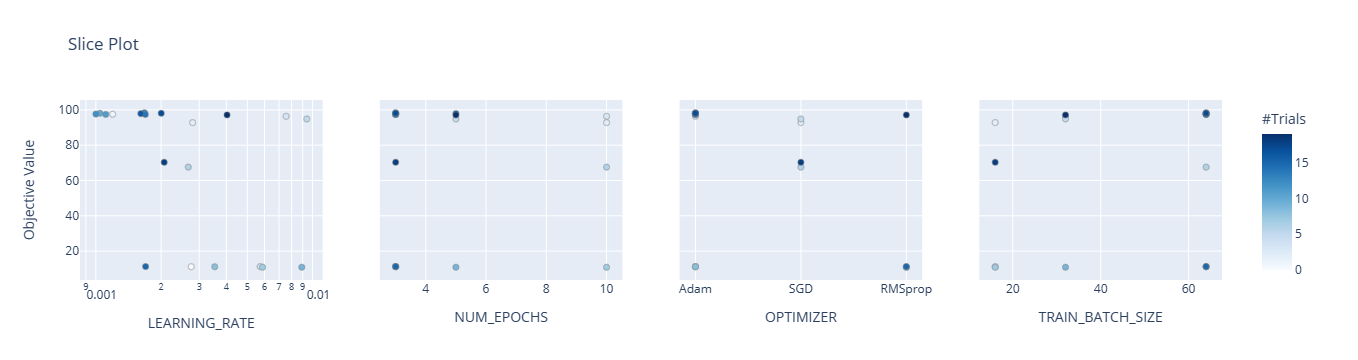

In [96]:
plot_slice(analysis_study)

#### Conclusion
> We can easily see that **ADAM** was able to give us better results, whereas RMSprop was able to perform good as well but not as good as ADAM so we have selected ADAM as the optimizer.
**Around 10 number of epochs** is a suffficient option to train the model if needs to achieve higher than 98 percent accuracy, since we got 98.370833 accuracy just by training for 3 epochs.
A range from 0.001 to 0.01 was used for selecting the best learning rate we can see from the results above that setting it to around **0.001** is the best option. Accuracy (objective value) using batch size 64 has increased the duration time but the better accuracy is achieved when using **64 batch size**.

### 2.3.5: Fit Model

In [8]:

DATA_PATH = 'D:\Repos\MLCS_Project_Assignments\\'
set_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
training_params = {
        'TRAIN_BATCH_SIZE' : 64,
        'TEST_BATCH_SIZE' : 1000,
        'LEARNING_RATE' : 0.001,
        'OPTIMIZER': optim.Adam,
        'NUM_EPOCHS' : 10
}

model_params = {
        'INPUT_SIZE' : 1,
        'HIDDEN_LAYERS' : [160, 100, 64, 10],
        'OUTPUT_SIZE' : 10,
        'KERNEL' : 3,
        'STRIDE' : 1,
        'PADDING' : 1
}
    
train_loader, validation_loader, test_loader = _get_data(DATA_PATH, training_params['TRAIN_BATCH_SIZE'], training_params['TEST_BATCH_SIZE'])
    
model = CNN_Network(model_params).to(set_device)
print(f'Network structure is: {model.parameters}')
print(f'Total number of parameters: {sum(p.numel() for p in model.parameters())}')

criterion = nn.CrossEntropyLoss().to(set_device)
optimizer = training_params['OPTIMIZER'](model.parameters(), lr=training_params['LEARNING_RATE'])
model.load_state_dict(torch.load('Accuracy_99.9_batchsize_64_lr_0.0016.ckpt' ))
train_loss, validation_loss, train_acc, validation_acc = _network_training(model, train_loader, validation_loader, criterion, optimizer, training_params, set_device)


Network structure is: <bound method Module.parameters of CNN_Network(
  (layers): Sequential(
    (0): Conv2d(1, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(160, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(100, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(64, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=10, out_features=10, bias=True)
  )
)>
Total number of parameters: 209244
Epoch : [1/10] | Step : [100/750] | Loss : 0.0074408496

### 2.3.6: Evaluation

Evaluate your model.

  * Loss curves: Plot epoch (# passes over training data) and loss
  * Accuracy curves: Plot epoch and accuracy over val/test set
  * Final numbers: Report final accuracy numbers for your model

In [9]:

def _test_model(model, test_loader, BEST_MODEL):
    try:
        model.load_state_dict(torch.load(BEST_MODEL))
        set_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        with torch.no_grad():
            correct_predictions = []
            testing_acc_scores = []
            wrong_predictions = []
            all_targets = []
            all_preds = []


            for images, targets in iter(test_loader):
                images = images.to(set_device)
                targets = targets.to(set_device)
                outputs = model(images)
                
                _, preds = torch.max(outputs, 1)
                correct_indicies = (preds == targets).nonzero(as_tuple=True)[0]
                c_images = images[correct_indicies]
                c_targets = targets[correct_indicies]
                c_wrong_preds = preds[correct_indicies]
                testing_acc_scores.append(len(correct_indicies)/targets.shape[0])

                wrong_indicies = (preds != targets).nonzero(as_tuple=True)[0]
                w_images = images[wrong_indicies]
                w_targets = targets[wrong_indicies]
                w_wrong_preds = preds[wrong_indicies]
            
                correct_predictions += zip(c_images, c_targets, c_wrong_preds)
                wrong_predictions += zip(w_images, w_targets, w_wrong_preds)
                all_targets+= zip(targets.cpu().numpy())
                all_preds+= zip(preds.cpu().numpy())

            return (sum(testing_acc_scores)/len(testing_acc_scores))*100, correct_predictions, wrong_predictions, all_targets, all_preds
        
    except Exception as e:
            print('Error occured in testing the model = ', e)
       

In [38]:
test_accuracy, correct_predictions, wrong_predictions, all_targets, all_preds = _test_model(model, test_loader, BEST_MODEL='Accuracy_99.96_batchsize_64_lr_0.001.ckpt' )

In [39]:
len(correct_predictions)

9923

In [40]:
len(wrong_predictions)

77

### Loss curves: Plot epoch (# passes over training data) and loss

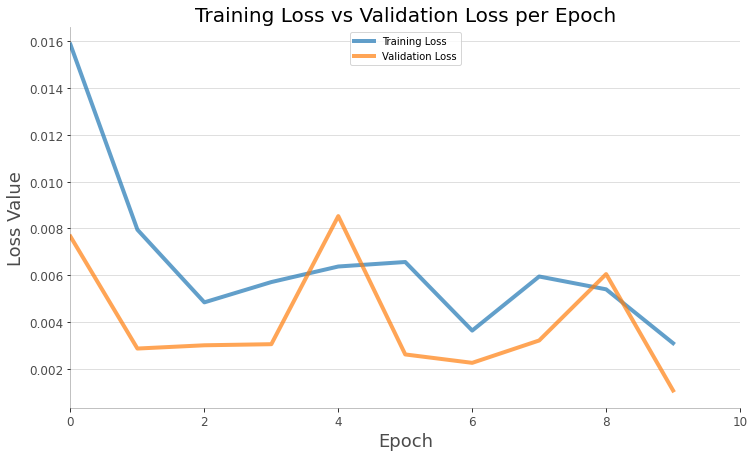

In [93]:

df = pd.DataFrame({'Training Loss':train_loss, 'Validation Loss':validation_loss})
df.plot(linewidth=4, alpha=0.7, figsize=(12,7), label='Loss')
plt.xlim([0,10])
# plt.ylim(-20,100)
plt.title('Training Loss vs Validation Loss per Epoch', fontsize=20)
plt.grid(axis='y', alpha=.5)
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.xlabel('Epoch', fontsize=18, alpha=.7)
plt.ylabel('Loss Value', fontsize=18, alpha=.7)
# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper center')
plt.show()


### Loss curves: Plot epoch (# passes over training data) and loss

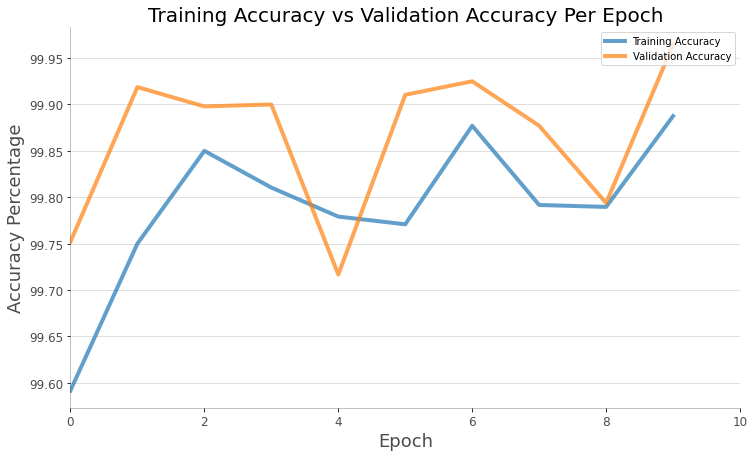

In [92]:
# Here plot epoch and accuracy over val/test set

df = pd.DataFrame({'Training Accuracy':train_acc, 'Validation Accuracy':validation_acc})
df.plot(linewidth=4, alpha=0.7, figsize=(12,7), label='Loss')
plt.xlim([0,10])
# plt.ylim(-20,100)
plt.title('Training Accuracy vs Validation Accuracy Per Epoch', fontsize=20)
plt.grid(axis='y', alpha=.5)
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.xlabel('Epoch', fontsize=18, alpha=.7)
plt.ylabel('Accuracy Percentage', fontsize=18, alpha=.7)
# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper right')
plt.show()

We got the best model at Epoch : 4  where the accuracy was highest | **Training Accuracy : 99.885%** | **Validation Accuracy 99.964%**
After that validation accuracy started to decrease as well as the training accuracy.

### Correct Predictions

Below is the visualizations of the digits that were predicted correct as by the trained model durinig the testing.

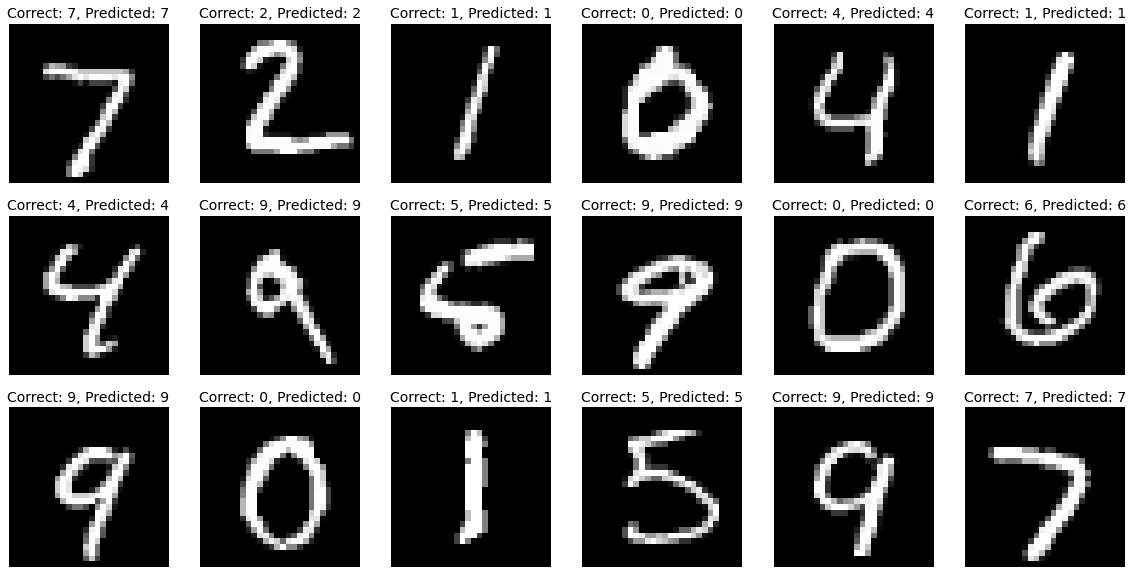

In [43]:
visualize_specific_predictions(correct_predictions)

### Wrong Predictions
Below is the visualizations of the digits that were predicted correct as by the trained model durinig the testing.
We can observe from some of the samples that the digits that are incorrectly predicted are actually very close to the predicted value but are obviously not.

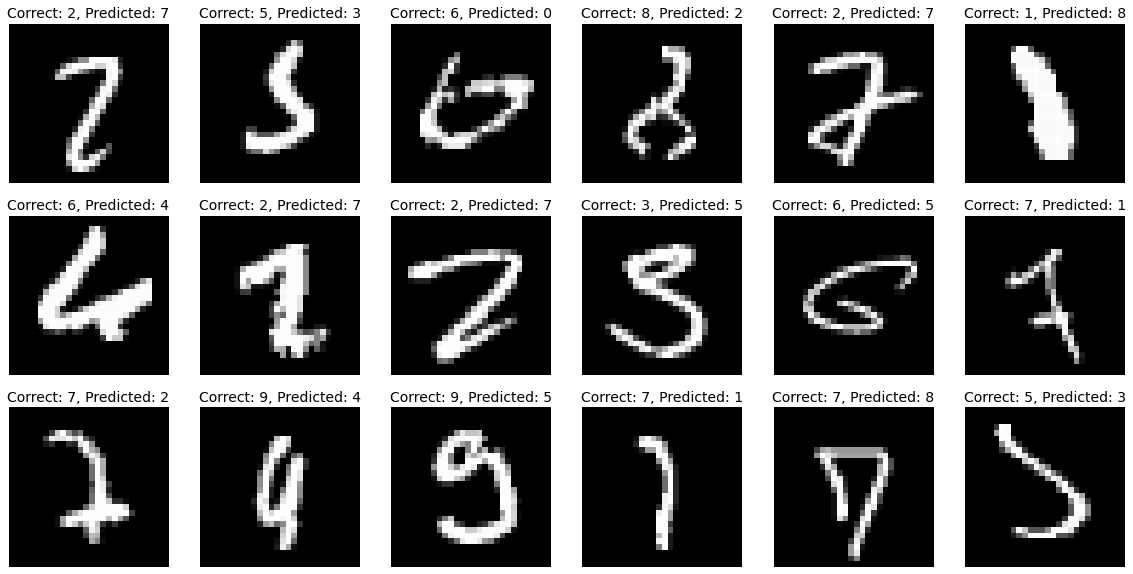

In [44]:
visualize_specific_predictions(wrong_predictions)

### Final numbers: Report final accuracy numbers for your model

In [46]:
print(f'Accuracy of the network on the training dataset: {max(train_acc)}')
print(f'Accuracy of the network on the validation dataset: {max(validation_acc)}')
print(f'Accuracy of the network on the test dataset: {round(test_accuracy,4)}')

Accuracy of the network on the training dataset: 99.88749999999999
Accuracy of the network on the validation dataset: 99.96458333333334
Accuracy of the network on the test dataset: 99.23


### Classification Report and Confusion Matrix

In [47]:
print(sklearn.metrics.classification_report(all_targets, all_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.98      0.99      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### 2.3.7: Summary

Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
 * What were other design choices you faced?
 * Any other interesting insights...

### Which hyper-parameters were important and how did they influence your results?
> From the results of the hyper parameter tuning we can summarize and visualize in the plot below that for our network, **values by the optimizer and the values of learning_rate had significance importance on our objective value (accuracy of the model)**. Adam was able to display good results and contributed well in the accuracy value along with the learning rate 0.001 that too within 10 epochs, using this setting we were able to reach more than **99.964** percent accuracy.

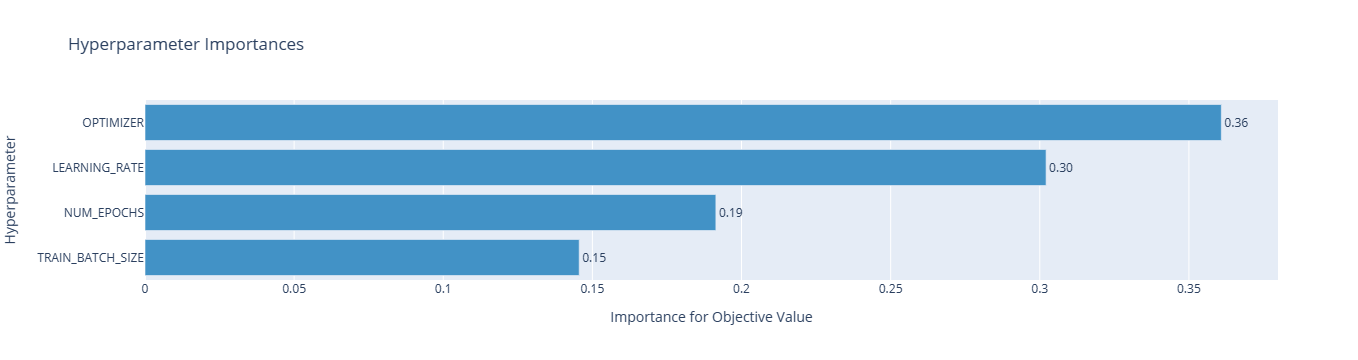

In [ ]:
plot_param_importances(analysis_study)

> Parallel coordinate plot displays the dependence of the objective value (accuracy of the model) with respect to the hyper parameters. We can observe clearly that we got the lowest accuracy due to higher learning rate than 0.001. Also SGD and RMSprop were not giving better accuracy as compare to ADAM. We can visualize different combinations that lead us to the specific accuracy and from this we can come up with our optimal path as well. 
We can easily see that both **Batch 32** and **Batch 64** were are able to give us better results if we use ADAM.
Irrespective of the **number of epochs** we were still able to achieve higher than 98 percent accuracy.
The learning rate is better if set to lower than **0.009** and goes accuracy higher as it goes lower from 0.0094 upto **0.001**. 

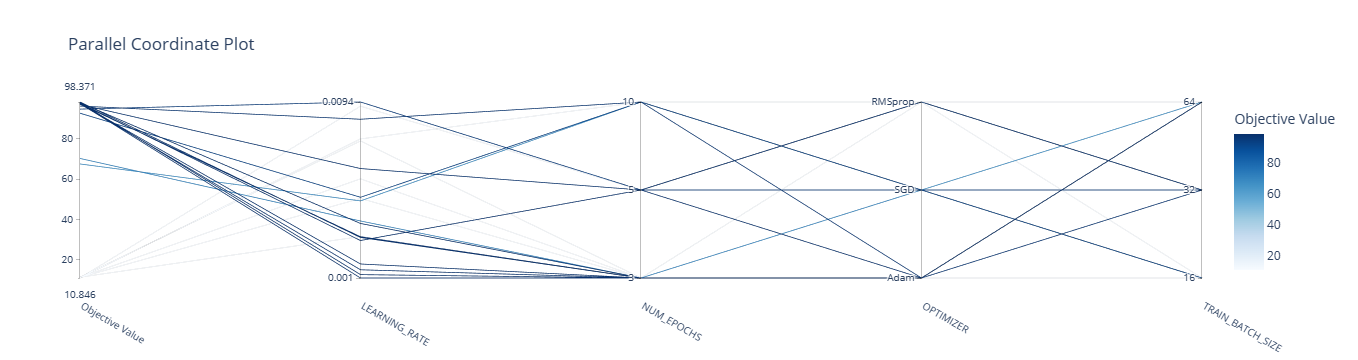

In [128]:
plot_parallel_coordinate(analysis_study)

> Below graph shows the history of the optimization trials that were conducted and this plot we can observe that trial 3 was able to achieve a higher accuracy (objective value) and after that the next trial 5 was able to supercede the results of the trial 2. Both doesnot have major difference in objective value and could be selected for hyperparameters. One is from ADAM another is fro RMSPROP

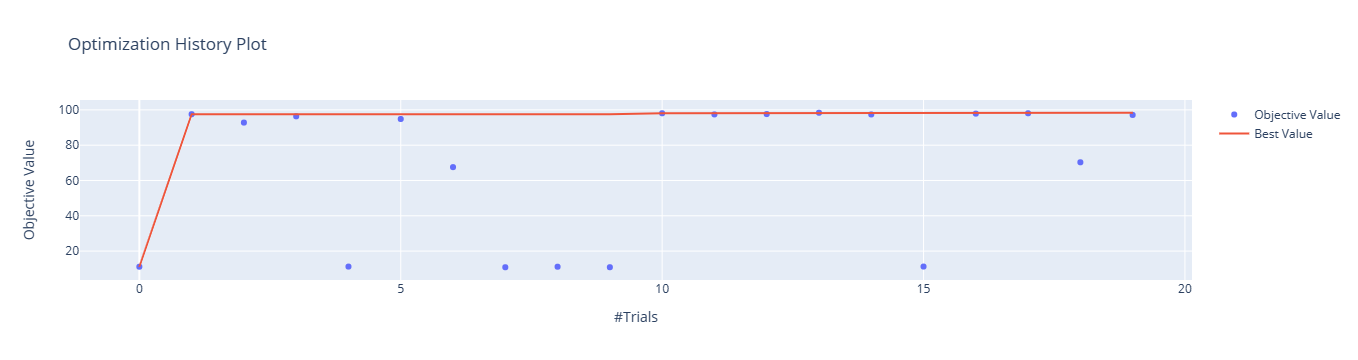

In [129]:
plot_optimization_history(analysis_study)

### What were other design choices you faced?
> Accuracy was able to reach upto 99.9 percent with a simple 4 layered CNN model. So the network was initiated simple and was not made further complex. However some regularisation techniques like dropout and inclusion of data augmentation was tried but including them however resulted in lower accuracy so they were not considered. 

### Any other interesting insights

> Typically, ADAM is considered to be a best optimizer and has been our selection for training the network. However, the model was also tried with RMSProp and it proved to give best results as well almost as similar as ADAM. Moreover, randomly selected trials during the hyperparameter tuning did not use RMSprop as much so a more exhaustive hyperparamter search can also be performed to get even better hyperparameter set is also a possibility.

# 3. Summary (20 points)

Enter your final summary here.

You should now compare performance  on the three models [M1], [M2] and [M3]. Present this in a tabular format and/or using plots.

Which model do you recommend to perform digit classification and why?

Feel free to discuss other insightful observations.

In [15]:
M1 = 'K-Nearest Neighbour'
M2 = 'Random Forest'
M3 = 'ConvNet'

#### Final Results

In [41]:
compare_report = pd.DataFrame({'Model Approach' : [M1, M2, M3], 'Dev Accuracy' : [97.8, 96.85, 99.9645], 'Testing Accuracy' : [96.59, 96.87, 99.23], 
                               'F1 scores': ['0.95 ~ 0.98', '0.95 ~ 0.98', '0.99 ~ 1.00'], 
                               'Precision': ['0.95 ~ 0.97', '0.95 ~ 0.98', '0.99 ~ 1.00'], 'Recall': ['0.93 ~ 1.00', '0.95 ~ 0.99', '0.99 ~ 1.00']  })
compare_report.set_index('Model Approach', inplace=True)
compare_report

,Dev Accuracy,Testing Accuracy,F1 scores,Precision,Recall
Model Approach,,,,,
K-Nearest Neighbour,97.8000,96.59,0.95 ~ 0.98,0.95 ~ 0.97,0.93 ~ 1.00
Random Forest,96.8500,96.87,0.95 ~ 0.98,0.95 ~ 0.98,0.95 ~ 0.99
ConvNet,99.9645,99.23,0.99 ~ 1.00,0.99 ~ 1.00,0.99 ~ 1.00


> In terms of Dev and Testing accuracy CONVNet supercedes with highest accuracy. In terms of simplicity, KNN model (one hyperparameter k-value) was a comparitively a very simple model and yet was able to achieve this much higher accuracy with the combiination of PCA reduction.
> CONVNet is highly recommended on the basis of accuracy but if one wants to not get involve with alot of hyper parameters and does not want to invest much on model architecture due to time-constraints, training complexities or low memory then KNN model approach with PCA reduction for a simple task as digit classifiation works fine as well.
>However, based on performance, scalability (different architectures) and generalizability(going deep) neural networks allow wide variety of options and so, we'd recommend CONVNet as the first choice algorith for digit classification problem.

#### Comparison of Classification Reports

##### KNN MODEL BASED APPROACH

In [284]:
print(classification_report(y_eval.numpy(), y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       980
         1.0       0.97      1.00      0.98      1135
         2.0       0.96      0.96      0.96      1032
         3.0       0.96      0.95      0.96      1010
         4.0       0.97      0.96      0.97       982
         5.0       0.96      0.97      0.97       892
         6.0       0.97      0.98      0.98       958
         7.0       0.96      0.96      0.96      1028
         8.0       0.97      0.93      0.95       974
         9.0       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



##### RANDOM FOREST MODEL BASED APPROACH

In [132]:
print(classification_report(y_eval.numpy(), y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1175
         1.0       0.98      0.99      0.98      1322
         2.0       0.95      0.97      0.96      1174
         3.0       0.97      0.95      0.96      1219
         4.0       0.97      0.97      0.97      1176
         5.0       0.97      0.96      0.97      1104
         6.0       0.98      0.98      0.98      1177
         7.0       0.97      0.96      0.97      1299
         8.0       0.96      0.96      0.96      1160
         9.0       0.95      0.95      0.95      1194

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



##### CONVNET MODEL BASED APPROACH

In [47]:
print(sklearn.metrics.classification_report(all_targets, all_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.98      0.99      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



- Overall, classification report of CONVNET based approach is comparitively far better than the other two approaches.
- Noticebly, in CONVNet classification report, F1 score for digit 0 and digit 3 is 100 precent (digit 0 is perfectly being classified)
- Random Forest as compare to K Nearest Neighbor gave better combinations of precision, recall and f1-score.
- In KNN based classification report, digits 8 and 9 have the low F1 scores.
- In Random Forest classification report, digit 9 has the lowest F1 score.
- Critical digits (considering 8 and 9) are classified fine by CONVNet based approach as per the classification report.

#### Comparison of Confusion Matrix

##### KNN MODEL BASED APPROACH

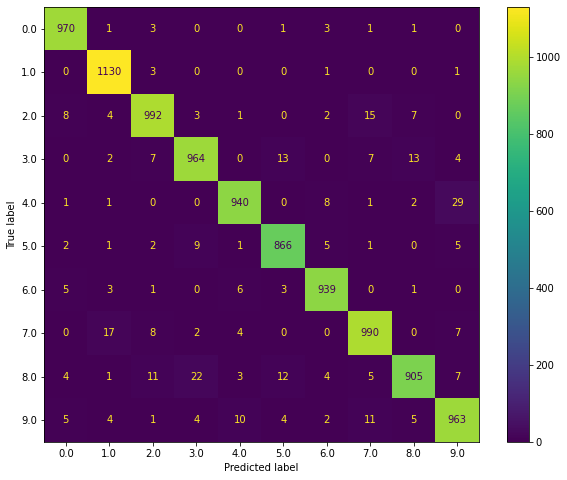

In [283]:
plot_confusion_matrix(best_knn_model, pca_eval_outputs[50], y_eval.numpy()); ##### KNN Approach

- Digit 1 is was the most correctly predicted number
- Digit 4 is the most incorrectly predicted number as 9, followed by 8 being predicted as 3.
- Digits 0, 1, 5, and 6 have a good true-predicted ratio 
- Digit 8 is being classified as 2, 3 and 5 more than 10 times (resulting in lowest F1 score)
- Digit 9 as well is being misclassified as 4 and 7 more than 10 times (resulting in lowest F1 score)

##### RANDOM FOREST MODEL BASED APPROACH

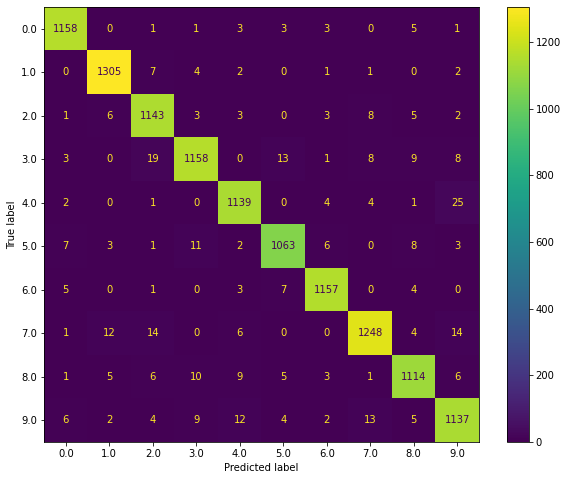

In [131]:
plot_confusion_matrix(best_rf_model, x_eval_flat, y_eval.numpy()); ##### Random Forest Approach

- Digit 1 is was the most correctly predicted number (similar to KNN)
- Digit 4 is the most incorrectly predicted number as 9 (but 4 samples less than KNN)
- As compared to KNN, digit 8 being predicted as 3 is very low (11 samples less than KNN). 
- Digits 0, 1, 2, and 6 have a good true-predicted ratio 
- Digit 9 is being misclassified as 4 and 7 more than 10 times (resulting in lowest F1 score); similar to KNN

##### CONVNET MODEL BASED APPROACH

In [148]:
cm = confusion_matrix(all_targets, all_preds) ##### CONVNET Approach
cm

<class 'numpy.ndarray'>


array([[ 977,    0,    0,    0,    0,    0,    1,    1,    1,    0],
       [   0, 1132,    0,    1,    0,    0,    0,    1,    1,    0],
       [   1,    0, 1016,    1,    0,    0,    0,   13,    1,    0],
       [   0,    0,    0, 1007,    0,    2,    0,    0,    1,    0],
       [   0,    1,    0,    0,  978,    0,    0,    0,    0,    3],
       [   0,    0,    0,    5,    0,  886,    1,    0,    0,    0],
       [   2,    4,    0,    0,    3,    2,  946,    0,    1,    0],
       [   0,    4,    1,    0,    0,    0,    0, 1019,    1,    3],
       [   1,    1,    1,    0,    0,    1,    0,    0,  969,    1],
       [   0,    1,    0,    0,    5,    5,    0,    2,    3,  993]],
      dtype=int64)

- Digit 1 is was the most correctly predicted number; similar to KNN and Random Forest
- Digit 2 is the most incorrectly predicted number as 7; not the case in KNN and Random Forest.
- All digits are being classified almost correctly misclassifcations are less than and equal to 5 samples.  